In [5]:
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np
import chess
import chess.pgn
import zstandard as zstd
import re
import io
import os.path
import json
import collections
from tqdm import tqdm

## Rating fluctuation

In [25]:
def calc_P_win(r1, r2): # assuming no draws
    return 1/(1+10**((r2-r1)/400))

def calc_expected_result(r1, r2):
    return 1/(1+10**((r2-r1)/400))

def calc_new_rating(result, exp, r1, K):
    """Calculate new ELO rating of player with rating `r1` given that
    their expected result was `exp` and the actual result was `result` (1 for
    win, 0 for loss). `K` is the K-factor used to determine how much
    the rating changes by."""
    return r1 + K*(result - exp)

In [26]:
K = 10
samples = 10
games_per_sample = 100
actual_rating = 1800
ratings_by_sample = []

for _ in range(samples):
    player_rating = actual_rating
    ratings_for_sample = [actual_rating]
    for i in range(games_per_sample):
        opponent_rating = player_rating
        P_win = calc_P_win(actual_rating, opponent_rating)
        result = 1 if random.random() < P_win else 0
        expected_result_for_rating = calc_expected_result(player_rating, opponent_rating)
        player_rating = calc_new_rating(result, expected_result_for_rating, player_rating, K)
        ratings_for_sample.append(player_rating)
    ratings_by_sample.append(ratings_for_sample)

Text(0, 0.5, 'Rating Change')

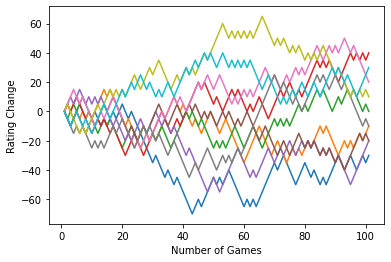

In [28]:
xs = list(range(1, len(ratings_by_sample[0])+1))
for ys in ratings_by_sample:
    plt.plot(xs, [y-actual_rating for y in ys])
plt.xlabel("Number of Games")
plt.ylabel("Rating Change")

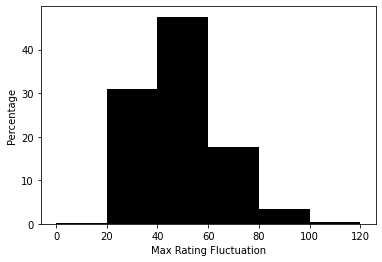

In [167]:
hikes = []
for rs in ratings_by_sample:
    hikes.append(max(abs(r-actual_rating) for r in rs))
plt.hist(hikes,
         color="black",
         weights=100 * np.ones_like(hikes) / len(hikes),
         bins=list(range(0, int(max(hikes))+1, 20)))
plt.xlabel("Max Rating Fluctuation")
plt.ylabel("Percentage")
plt.savefig("/tmp/fluctuation-hist.png")

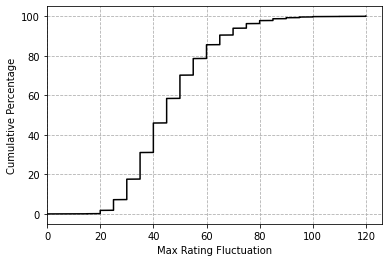

In [168]:
hikes = []
for rs in ratings_by_sample:
    hikes.append(max(abs(r-actual_rating) for r in rs))
hikes.sort()
count = 0
xs = [0]
ys = [0]
for h in hikes:
    count += 1
    ys.append(count/len(hikes)*100)
    xs.append(h)
plt.plot(xs, ys, color="black")
plt.xlabel("Max Rating Fluctuation")
plt.ylabel("Cumulative Percentage")
plt.grid(linestyle="--")
plt.xlim(left=0)
plt.savefig("/tmp/fluctuation-cumulative.png")

In [ ]:
actual_rating = 1800
opponent_ratings = list(range(1200, 2400, 50))
plt.plot([opp_rating - actual_rating for opp_rating in opponent_ratings],
         [calc_P_win(actual_rating, opp_rating) for opp_rating in opponent_ratings],
         label="1800 ELO",
         color="black")
plt.xlabel("Opponent ELO Rating")
plt.ylabel("Win Probability")
plt.grid(linestyle="--")
plt.legend()

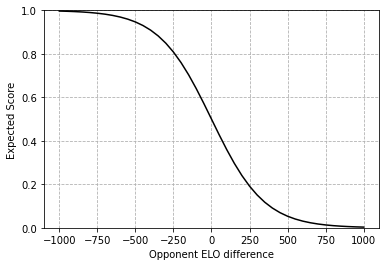

In [113]:
opps = list(range(800, 2801, 50))
plt.plot([opp-actual_rating for opp in opps],
         [calc_expected_result(actual_rating, opp) for opp in opps],
         color="black")
plt.xlabel("Opponent ELO difference")
plt.ylabel("Expected Score")
plt.ylim(bottom=0, top=1)
plt.grid(linestyle="--")
plt.savefig("/tmp/expected-result.png")

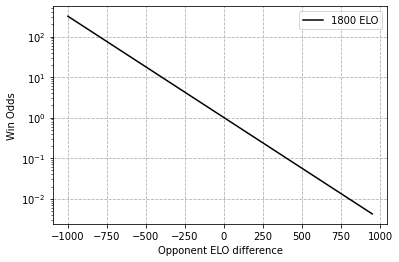

In [15]:
opps = list(range(800, 2800, 50))
ys = []
for opp in opps:
    P_win = calc_P_win(actual_rating, opp)
    win_odds = P_win/(1-P_win)
    ys.append(win_odds)
plt.plot([opp-actual_rating for opp in opps],
         ys,
         label="1800 ELO",
         color="black")
plt.xlabel("Opponent ELO difference")
plt.ylabel("Win Odds")
plt.yscale("log")
plt.grid(linestyle="--")
plt.legend()

#### Now the same thing but exact probabilities using Markov model 

In [42]:
N = 100 # number of games
N_s = 2*N+1 # number of possible ratings
X = np.zeros((N_s, N_s)) # transition matrix
for i in range(N_s):
    r_A = 1800 # our strength / true rating is fixed (actual rating is not)
    r_B = 5*(i-N) + r_A # opponent's rating is same as our actual rating
    P_win = calc_P_win(r_A, r_B)
    if i < N_s-1:
        X[i+1, i] = P_win
    if i > 0:
        X[i-1, i] = 1-P_win
y = np.zeros(N_s)
y[N] = 1 # all initial probability on start rating

In [43]:
distr = np.dot(np.linalg.matrix_power(X, N), y)

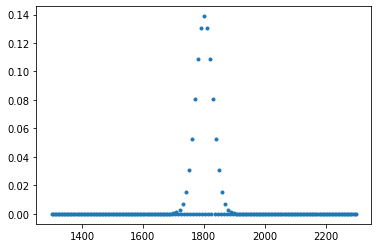

In [44]:
ratings = np.arange(-5*N+1800, 5*N+1800+1, 5)
plt.plot(ratings, distr, marker=".", linestyle="")

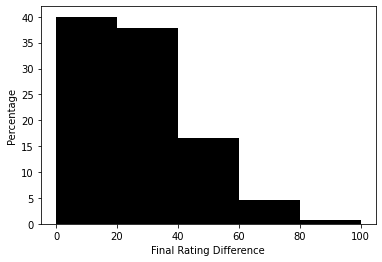

In [45]:
diffs = np.abs(1800-ratings)
buckets = [(0,20), (20, 40), (40, 60), (60,80), (80,100)]
xs = []
ys = []
for lo, hi in buckets:
    xs.append(lo)
    ys.append(np.sum(distr[np.where((diffs >= lo) & (diffs < hi))]))
plt.bar(xs,
        [100*y for y in ys],
        align="edge",
        color="black",
        width=20)
plt.xlabel("Final Rating Difference")
plt.ylabel("Percentage")
plt.savefig("/tmp/distr-markov.png")

In [174]:
avg = np.dot(diffs, distr)
print("Average difference:", avg)
print("Standard dev:", np.sqrt(np.dot(distr, (diffs-avg)**2)))

Average difference: 22.70021524852573
Standard dev: 17.626168460277462


## Interface to Lichess database

In [180]:
def stream_games(n=None):
    n_games = 0
    with open("data/lichess_db_standard_rated_2024-03.pgn.zst", "rb") as f:
        decomp = zstd.ZstdDecompressor(max_window_size=2147483648)
        prev_string = None
        with decomp.stream_reader(f) as reader:
            while (not n) or n_games < n:
                chunk = reader.read(16000000)
                if not chunk:
                    break
                s = chunk.decode('utf-8')
                if prev_string:
                    s = prev_string + s
                    prev_string = None
                ss = io.StringIO(s)
                while (not n) or n_games < n:
                    i = ss.tell()
                    game = chess.pgn.read_game(ss)
                    if not game:
                        prev_string = s[i:]
                        break
                    yield game
                    n_games += 1

## Collecting a sample of players

In [181]:
target_players = 10000
count = 0
players = set()
for game in stream_games():
    if "White" in game.headers: players.add(game.headers["White"])
    if "Black" in game.headers: players.add(game.headers["Black"])
    num_players = len(players)
    if num_players >= target_players:
        break
    frac = num_players/target_players
    if count/10 < frac:
        print("Proportion accumulated:", frac)
        count += 1

Proportion accumulated: 0.0002
Proportion accumulated: 0.1002
Proportion accumulated: 0.2002
Proportion accumulated: 0.3001
Proportion accumulated: 0.4001
Proportion accumulated: 0.5001
Proportion accumulated: 0.6001
Proportion accumulated: 0.7001
Proportion accumulated: 0.8002
Proportion accumulated: 0.9002


In [184]:
with open("data/players.txt", "w") as f:
    for player in players:
        f.write(player)
        f.write("\n")

## ELO predictive value
Lichess games: https://database.lichess.org/

Useful headers in PGN data:
- Termination = {'Abandoned', 'Normal', 'Time forfeit'}
- Result = {'1-0', '0-1', '1/2-1/2'}

Also useful:

- https://lichess.org/page/rating-systems
- http://www.glicko.net/glicko/glicko2.pdf
- https://www.kaggle.com/c/ChessRatings2/overview
- https://python-chess.readthedocs.io/en/latest/pgn.html

In [84]:
def estimate_score(expected, actual):
    return (expected-actual)**2

N = 10000
rating_keys = ["BlackElo", "WhiteElo"]
player_ids = [0, 1]
elo_sum = 0
random_sum = 0
for game in stream_games(n=N):
    # shuffle to average out the error from white vs black
    random.shuffle(player_ids)
    p1, p2 = player_ids[0], player_ids[1]
    print(game.headers)
    r1, r2 = (int(game.headers[rating_keys[p1]]),
              int(game.headers[rating_keys[p2]]))
    result = game.headers["Result"]
    if (p1 == 0 and result == "0-1"
            or p1 == 1 and result == "1-0"):
        score = 1
    elif (p1 == 0 and result == "1-0"
            or p1 == 1 and result == "0-1"):
        score = 0
    else:
        score = .5
    elo_expected = calc_expected_result(r1, r2)
    random_expected = .5
    elo_sum += estimate_score(elo_expected, score)
    random_sum += estimate_score(random_expected, score)
    #print("Player 1 colour", rating_keys[p1].replace("Elo", ""))
    #print("Player 1 rating", r1)
    #print("Player 2 rating", r2)
    #print("Result:", result)
    #print("ELO expected", elo_expected)
    #print("Actual score", score)
    #print("=======")
elo_score = elo_sum/N
random_score = random_sum/N

Headers(Event='Rated Bullet game', Site='https://lichess.org/DW2E2sO9', Date='2024.03.01', Round='-', White='Parteset', Black='ReneSeguel', Result='0-1', BlackElo='1452', BlackRatingDiff='+53', ECO='C02', Opening='French Defense: Advance Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:18', WhiteElo='1514', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/XO1jlp8p', Date='2024.03.01', Round='-', White='MBotvinnniK_5-0', Black='NextKinghunt', Result='1-0', BlackElo='2076', BlackRatingDiff='-5', ECO='B20', Opening='Sicilian Defense: Wing Gambit, Marshall Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:18', WhiteElo='2142', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/NgRbjXYB', Date='2024.03.01', Round='-', White='ChessSecret_69', Black='zitronat', Result='1-0', BlackElo='1925', BlackRatingDiff='-6', ECO='B13', Opening='Caro-Ka

Headers(Event='Rated Blitz game', Site='https://lichess.org/xW3e3Qxb', Date='2024.03.01', Round='-', White='st4rless', Black='Khaled0791', Result='0-1', BlackElo='1425', BlackRatingDiff='+6', ECO='A45', Opening='Indian Defense', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:00:19', WhiteElo='1454', WhiteRatingDiff='-24')
Headers(Event='Rated Blitz game', Site='https://lichess.org/lhJ1swS9', Date='2024.03.01', Round='-', White='margathon', Black='zachpepsin', Result='0-1', BlackElo='1514', BlackRatingDiff='+8', ECO='B10', Opening='Caro-Kann Defense', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:00:19', WhiteElo='1598', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/tiokF9cP', Date='2024.03.01', Round='-', White='Iranmagician', Black='Monty_69', Result='1-0', BlackElo='1774', BlackRatingDiff='-6', ECO='A41', Opening='Rat Defense: English Rat', Termination='Normal', TimeControl='180+2',

Headers(Event='Rapid swiss https://lichess.org/swiss/MWhJDvd1', Site='https://lichess.org/A8vNWeks', Date='2024.03.01', Round='-', White='Gabriel-AS-OHES', Black='David-Z-OHES', Result='0-1', BlackElo='1422', BlackRatingDiff='+3', ECO='C61', Opening='Ruy Lopez: Bird Variation', Termination='Time forfeit', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:00', WhiteElo='1143', WhiteRatingDiff='-5')
Headers(Event='Rapid swiss https://lichess.org/swiss/MWhJDvd1', Site='https://lichess.org/EcZZWPep', Date='2024.03.01', Round='-', White='Ameer-A-OHES', Black='Marcus-h-OHES', Result='1-0', BlackElo='1197', ECO='A04', Opening='Zukertort Opening', Termination='Time forfeit', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:00', WhiteElo='1472')
Headers(Event='Rapid swiss https://lichess.org/swiss/MWhJDvd1', Site='https://lichess.org/gR4Wm7L1', Date='2024.03.01', Round='-', White='CGES016', Black='Brandon-C-OHES', Result='0-1', BlackElo='1517', BlackRatingDiff='+3', ECO='C50', 

Headers(Event='Rated Bullet game', Site='https://lichess.org/Pmqbr0mk', Date='2024.03.01', Round='-', White='xela58', Black='aniprin', Result='1-0', BlackElo='1516', BlackRatingDiff='-6', ECO='C00', Opening='French Defense: Knight Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:21', WhiteElo='1505', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/kFS5lEq0', Date='2024.03.01', Round='-', White='germano_miranda', Black='kennikilla', Result='0-1', BlackElo='1999', BlackRatingDiff='+6', ECO='A04', Opening='Zukertort Opening: Pirc Invitation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:21', WhiteElo='1998', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/7yoo26WU', Date='2024.03.01', Round='-', White='ilostmytrack', Black='FBF633', Result='1-0', BlackElo='1422', BlackRatingDiff='-6', ECO='A01', Opening='Nimzo-Larsen Attack', Termination='

Headers(Event='Rated Rapid game', Site='https://lichess.org/9OJXyEwx', Date='2024.03.01', Round='-', White='klement123', Black='kukaradze1963', Result='0-1', BlackElo='1922', BlackRatingDiff='+7', ECO='A21', Opening="English Opening: King's English Variation, Reversed Sicilian", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:23', WhiteElo='1941', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/q2q1wDEZ', Date='2024.03.01', Round='-', White='dancristo', Black='emanuelmisael', Result='0-1', BlackElo='1571', BlackRatingDiff='+6', ECO='B30', Opening='Sicilian Defense: Old Sicilian', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:23', WhiteElo='1597', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/WGQbCpEe', Date='2024.03.01', Round='-', White='NumpaloidxD', Black='super_uzer', Result='0-1', BlackElo='1840', BlackRatingDiff='+7', ECO='A00', Opening='Polish O

Headers(Event='Rated Blitz game', Site='https://lichess.org/71JdpR2h', Date='2024.03.01', Round='-', White='nkmb66', Black='jamilsilva', Result='0-1', BlackElo='1550', BlackRatingDiff='+6', ECO='D02', Opening="Queen's Pawn Game: Chigorin Variation", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:10', WhiteElo='1545', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/Q8qprRUR', Date='2024.03.01', Round='-', White='carneva', Black='Achrafba727237', Result='1-0', BlackElo='1030', BlackRatingDiff='-5', ECO='D00', Opening="Queen's Pawn Game: Accelerated London System", Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:00:10', WhiteElo='1131', WhiteRatingDiff='+4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/IT3osZqt', Date='2024.03.01', Round='-', White='toponimio', Black='Fair_Chess00', Result='0-1', BlackElo='2044', BlackRatingDiff='+8', ECO='E60', Opening='Indian Defense: West Ind

Headers(Event='Rated Bullet game', Site='https://lichess.org/WDMlGJMV', Date='2024.03.01', Round='-', White='Moskva2117', Black='jaynou', Result='1-0', BlackElo='2209', BlackRatingDiff='-5', ECO='A40', Opening='English Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:12', WhiteElo='2279', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/jww3amu2', Date='2024.03.01', Round='-', White='cleonaara', Black='her1378', Result='1-0', BlackElo='1997', BlackRatingDiff='-6', ECO='A00', Opening='Mieses Opening', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:12', WhiteElo='2006', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/yqtOb2x9', Date='2024.03.01', Round='-', White='Chess621', Black='schnecken_bot', Result='1-0', BlackElo='1495', BlackRatingDiff='-4', ECO='D01', Opening='Rapport-Jobava System', Termination='Normal', TimeControl='60+3', UTCD

Headers(Event='Rated Blitz game', Site='https://lichess.org/mqtprWjX', Date='2024.03.01', Round='-', White='OliversArmy69', Black='jewome', Result='1-0', BlackElo='1067', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Defense', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:20', WhiteElo='1010', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/4rcjKxYH', Date='2024.03.01', Round='-', White='breatheslowanddeep', Black='paulb969', Result='0-1', BlackElo='1600', BlackRatingDiff='+6', ECO='C40', Opening="King's Pawn Game: Busch-Gass Gambit", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:20', WhiteElo='1602', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/KO56rZZP', Date='2024.03.01', Round='-', White='takedowntownietown', Black='KingMigo21', Result='0-1', BlackElo='1302', BlackRatingDiff='+5', ECO='A00', Opening="Van't Kruijs Opening", Termina

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/WkVS3bNx', Site='https://lichess.org/t0gwWqVM', Date='2024.03.01', Round='-', White='MACIEL40CHESS', Black='Lemuel2014', Result='0-1', BlackElo='2029', BlackRatingDiff='+12', ECO='B15', Opening='Caro-Kann Defense: Main Line', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:15', WhiteElo='2087', WhiteRatingDiff='-8')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/WkVS3bNx', Site='https://lichess.org/2o4IlxZJ', Date='2024.03.01', Round='-', White='Dantas51', Black='senhorestranho', Result='1/2-1/2', BlackElo='1816', BlackRatingDiff='-2', ECO='D06', Opening="Queen's Gambit Declined: Marshall Defense", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:15', WhiteElo='1750', WhiteRatingDiff='+1')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/WkVS3bNx', Site='https://lichess.org/r9vTuE20', Date='2024.03.01', Round

Headers(Event='Rated Bullet game', Site='https://lichess.org/vgmxa5gi', Date='2024.03.01', Round='-', White='thanigaiarasan', Black='visokos', Result='1-0', BlackElo='1224', BlackRatingDiff='-7', ECO='C00', Opening="French Defense: King's Indian Attack", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:15', WhiteElo='1061', WhiteRatingDiff='+140')
Headers(Event='Rated Bullet game', Site='https://lichess.org/RyhsjkA8', Date='2024.03.01', Round='-', White='jhojann', Black='Malikhash', Result='0-1', BlackElo='1819', BlackRatingDiff='+5', ECO='A40', Opening='English Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:15', WhiteElo='1798', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/Tqnwdtmj', Date='2024.03.01', Round='-', White='Sabocley', Black='sagae', Result='1-0', BlackElo='1606', BlackRatingDiff='-5', ECO='C34', Opening="King's Gambit Accepted: Schallopp Defense", Terminatio

Headers(Event='Rated Blitz game', Site='https://lichess.org/J5ETqIVH', Date='2024.03.01', Round='-', White='Empilitre123', Black='AzadKerimov', Result='1-0', BlackElo='1839', BlackRatingDiff='-5', ECO='C21', Opening='Danish Gambit', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:00:24', WhiteElo='1840', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/7yIekTkY', Date='2024.03.01', Round='-', White='Chemist_Salah', Black='Lucianocapivara', Result='1-0', BlackElo='1536', BlackRatingDiff='-4', ECO='C01', Opening='French Defense: Exchange Variation', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:00:24', WhiteElo='1631', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/ijdcnB4K', Date='2024.03.01', Round='-', White='Desiretours', Black='Francis57co', Result='0-1', BlackElo='1462', BlackRatingDiff='+6', ECO='C69', Opening='Ruy Lopez: Exchange Variation, Alapin Gambit

Headers(Event='Rated Bullet game', Site='https://lichess.org/4LXj18cn', Date='2024.03.01', Round='-', White='samchu', Black='greyhorse', Result='1-0', BlackElo='1909', BlackRatingDiff='-6', ECO='A85', Opening="Dutch Defense: Queen's Knight Variation", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:25', WhiteElo='1920', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/fHkbIOkg', Date='2024.03.01', Round='-', White='ClairvoyantChess', Black='GasStationSpamMusubi', Result='0-1', BlackElo='1791', BlackRatingDiff='+6', ECO='A00', Opening='Mieses Opening: Reversed Rat', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:25', WhiteElo='1813', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/OZYfr31F', Date='2024.03.01', Round='-', White='hazemlemo', Black='giola', Result='0-1', BlackElo='1076', BlackRatingDiff='+4', ECO='B10', Opening='Caro-Kann Defense', Termi

Headers(Event='Rated Bullet game', Site='https://lichess.org/AFxQDSSa', Date='2024.03.01', Round='-', White='Rafffu', Black='Peeperkorn', Result='0-1', BlackElo='2294', BlackRatingDiff='+5', ECO='A40', Opening='Mikenas Defense', Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:00:06', WhiteElo='2215', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/iajcaC6y', Date='2024.03.01', Round='-', White='L45E', Black='babarolo', Result='1-0', BlackElo='1732', BlackRatingDiff='-5', ECO='A02', Opening='Bird Opening', Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:00:06', WhiteElo='1747', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/iHEmJLa3', Date='2024.03.01', Round='-', White='AgustinBarba', Black='BULL1976', Result='1-0', BlackElo='1111', BlackRatingDiff='-6', ECO='C42', Opening='Russian Game: Three Knights Game', Termination='Normal', TimeControl='120+

Headers(Event='Rated Blitz game', Site='https://lichess.org/bWlxyTIM', Date='2024.03.01', Round='-', White='monte_carlo174', Black='subaesel2', Result='1-0', BlackElo='1941', BlackRatingDiff='-6', ECO='A00', Opening='Polish Opening', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:00:07', WhiteElo='1974', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/kOkrJ34w', Date='2024.03.01', Round='-', White='sherdowman', Black='ginoonghalimaw', Result='1-0', BlackElo='1324', BlackRatingDiff='-4', ECO='B00', Opening='Pirc Defense', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:00:07', WhiteElo='1426', WhiteRatingDiff='+37')
Headers(Event='Rated Blitz game', Site='https://lichess.org/sqFKVciS', Date='2024.03.01', Round='-', White='Eduardoestadio', Black='malangel', Result='0-1', BlackElo='1653', BlackRatingDiff='+6', ECO='C55', Opening="Italian Game: Two Knights Defense, Modern Bishop's Opening", Termina

Headers(Event='Rated Rapid game', Site='https://lichess.org/xIVCow98', Date='2024.03.01', Round='-', White='marcosmolina', Black='LuanaEstefania', Result='0-1', BlackElo='1808', BlackRatingDiff='+21', ECO='B13', Opening='Caro-Kann Defense: Exchange Variation', Termination='Normal', TimeControl='900+3', UTCDate='2024.03.01', UTCTime='00:00:02', WhiteElo='1812', WhiteRatingDiff='-5')
Headers(Event='Rated UltraBullet game', Site='https://lichess.org/K3Gi0vn8', Date='2024.03.01', Round='-', White='schachgenie', Black='elrincondelopez', Result='1-0', BlackElo='1892', BlackRatingDiff='-7', ECO='A01', Opening='Nimzo-Larsen Attack', Termination='Time forfeit', TimeControl='15+0', UTCDate='2024.03.01', UTCTime='00:00:02', WhiteElo='1793', WhiteRatingDiff='+8')
Headers(Event='Rated Rapid game', Site='https://lichess.org/zH6v4TD4', Date='2024.03.01', Round='-', White='LJW2004', Black='tejasfulumbarkarr', Result='1-0', BlackElo='1066', BlackRatingDiff='-7', ECO='B10', Opening='Caro-Kann Defense: B

Headers(Event='Rated Bullet game', Site='https://lichess.org/HVfj5xG0', Date='2024.03.01', Round='-', White='MrSpeedyyy', Black='stockfish_alphazero', Result='1/2-1/2', BlackElo='1362', BlackRatingDiff='+0', ECO='A00', Opening='Mieses Opening', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:05', WhiteElo='1366', WhiteRatingDiff='+0')
Headers(Event='Rated Bullet game', Site='https://lichess.org/Ev2v6zsY', Date='2024.03.01', Round='-', White='Lets_Go_Hawks', Black='Herr_Gustav_Gambit', Result='0-1', BlackElo='2184', BlackRatingDiff='+2', ECO='B01', Opening='Scandinavian Defense', Termination='Normal', TimeControl='30+0', UTCDate='2024.03.01', UTCTime='00:00:05', WhiteElo='1954', WhiteRatingDiff='-3')
Headers(Event='Rated Blitz game', Site='https://lichess.org/6e3KG436', Date='2024.03.01', Round='-', White='fesenko77igor', Black='Aw-Naw29', Result='1-0', BlackElo='1771', BlackRatingDiff='-2', ECO='A10', Opening='English Opening: Anglo-Scandinavian Defense',

Headers(Event='Rated Blitz game', Site='https://lichess.org/XDVTmmVD', Date='2024.03.01', Round='-', White='bedakaa', Black='dafelisioso', Result='1-0', BlackElo='1762', BlackRatingDiff='-6', ECO='A07', Opening="King's Indian Attack: Keres Variation", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:02', WhiteElo='1734', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/0kv4WfKf', Date='2024.03.01', Round='-', White='Claudio1971', Black='tunnaka', Result='1-0', BlackElo='1844', BlackRatingDiff='-6', ECO='E20', Opening='Nimzo-Indian Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:02', WhiteElo='1865', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/6nPyIlZ0', Date='2024.03.01', Round='-', White='bajrushk', Black='Mekhael77', Result='1-0', BlackElo='2259', BlackRatingDiff='-6', ECO='B20', Opening='Sicilian Defense: Staunton-Cochrane Variation', 

Headers(Event='Rated Bullet game', Site='https://lichess.org/wkyT08zL', Date='2024.03.01', Round='-', White='Blue129', Black='F7Mongoose', Result='0-1', BlackElo='1944', BlackRatingDiff='+6', ECO='B00', Opening='Goldsmith Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:36', WhiteElo='1977', WhiteRatingDiff='-7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/Jhzxs0zi', Date='2024.03.01', Round='-', White='D-leserbe', Black='Kerim123321', Result='1-0', BlackElo='1811', BlackRatingDiff='-5', ECO='A41', Opening="Queen's Pawn Game", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:36', WhiteElo='1845', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/uy8Rf8Se', Date='2024.03.01', Round='-', White='yakalar35', Black='chessomorphic', Result='0-1', BlackElo='1929', BlackRatingDiff='+5', ECO='D05', Opening="Queen's Pawn Game: Colle System", Termination='Normal', Ti

Headers(Event='Rated Blitz game', Site='https://lichess.org/Qg1QwApY', Date='2024.03.01', Round='-', White='graygray', Black='hamo_ashraf', Result='1-0', BlackElo='854', BlackRatingDiff='-6', ECO='A45', Opening='Paleface Attack', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:38', WhiteElo='871', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/z0pRbwAQ', Date='2024.03.01', Round='-', White='eduarmarti7575', Black='abu__anas39', Result='1-0', BlackElo='1465', BlackRatingDiff='-3', ECO='C45', Opening='Scotch Game', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:38', WhiteElo='1595', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/90wb3Nqe', Date='2024.03.01', Round='-', White='mitchlldvs', Black='yotsume', Result='1-0', BlackElo='1771', BlackRatingDiff='-14', ECO='C45', Opening='Scotch Game', Termination='Normal', TimeControl='300+0', UTCDate='

Headers(Event='Rated Rapid game', Site='https://lichess.org/TvY7wAYP', Date='2024.03.01', Round='-', White='bodacious-123', Black='rajesh02', Result='1-0', BlackElo='1756', BlackRatingDiff='-7', ECO='C64', Opening='Ruy Lopez: Classical Variation', Termination='Time forfeit', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:14', WhiteElo='1713', WhiteRatingDiff='+7')
Headers(Event='Rated Rapid game', Site='https://lichess.org/HuyN2OrA', Date='2024.03.01', Round='-', White='LiuMingYeYing', Black='scdodi', Result='0-1', BlackElo='802', BlackRatingDiff='+4', ECO='A00', Opening='Grob Opening', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:14', WhiteElo='671', WhiteRatingDiff='-4')
Headers(Event='Rated Rapid game', Site='https://lichess.org/1VrFTblS', Date='2024.03.01', Round='-', White='Sense18', Black='traviesus_maximus', Result='0-1', BlackElo='1945', BlackRatingDiff='+43', ECO='B45', Opening='Sicilian Defense: Taimanov Variation, Normal Variatio

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/eucfYPTy', Site='https://lichess.org/V2ZL2yC7', Date='2024.03.01', Round='-', White='skandam', Black='greenteakitten', Result='1/2-1/2', BlackElo='1739', BlackRatingDiff='-12', ECO='D02', Opening="Queen's Pawn Game: Symmetrical Variation", Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:14', WhiteElo='1161', WhiteRatingDiff='+9')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/GIad1Fz1', Site='https://lichess.org/M0YSoMlI', Date='2024.03.01', Round='-', White='yio05', Black='Kaspesky98', Result='1/2-1/2', BlackElo='2361', BlackRatingDiff='+4', ECO='A30', Opening='English Opening: Symmetrical Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:15', WhiteElo='2457', WhiteRatingDiff='-2')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/GIad1Fz1', Site='https://lichess.org/bSSTPFt2', Date='2024.03.01', R

Headers(Event='Rated Blitz game', Site='https://lichess.org/eUQkva8z', Date='2024.03.01', Round='-', White='laboaarussa', Black='oscarpeloso', Result='1-0', BlackElo='2252', BlackRatingDiff='-7', ECO='A45', Opening='Indian Defense: Tartakower Attack', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:34', WhiteElo='2212', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/819pkloZ', Date='2024.03.01', Round='-', White='hundex', Black='Saillok', Result='0-1', BlackElo='2400', BlackRatingDiff='+8', ECO='A06', Opening='Zukertort Opening', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:34', WhiteElo='2560', WhiteRatingDiff='-8')
Headers(Event='Rated Blitz game', Site='https://lichess.org/5dzr7dEV', Date='2024.03.01', Round='-', White='saidjabbari67', Black='Tacticwinss', Result='0-1', BlackElo='2372', BlackRatingDiff='+6', ECO='A40', Opening="Queen's Pawn Game: Modern Defense", Termination='

Headers(Event='Rated Blitz game', Site='https://lichess.org/Dq11B8ku', Date='2024.03.01', Round='-', White='HJST7', Black='chavi408', Result='0-1', BlackElo='1493', BlackRatingDiff='+6', ECO='C50', Opening='Italian Game: Giuoco Piano', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:27', WhiteElo='1561', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/eO6cPQ3I', Date='2024.03.01', Round='-', White='still33', Black='seguritochupamaso', Result='1-0', BlackElo='1798', BlackRatingDiff='-6', ECO='B06', Opening='Modern Defense: Two Knights Variation', Termination='Time forfeit', TimeControl='120+0', UTCDate='2024.03.01', UTCTime='00:00:28', WhiteElo='1950', WhiteRatingDiff='+3')
Headers(Event='Rated Bullet game', Site='https://lichess.org/lBsJUFbN', Date='2024.03.01', Round='-', White='haze905', Black='ds00264', Result='0-1', BlackElo='1264', BlackRatingDiff='+8', ECO='B06', Opening='Modern Defense', Termination='Time forfeit

Headers(Event='Rated Blitz game', Site='https://lichess.org/QrvqvI5t', Date='2024.03.01', Round='-', White='James_Chess007', Black='Mathematikoon', Result='0-1', BlackElo='1764', BlackRatingDiff='+6', ECO='C22', Opening='Center Game: Berger Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:29', WhiteElo='1751', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/xEMBj250', Date='2024.03.01', Round='-', White='sammmyboy', Black='MacaleD', Result='0-1', BlackElo='1709', BlackRatingDiff='+5', ECO='A45', Opening='Indian Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:29', WhiteElo='1704', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/CKfuvRmu', Date='2024.03.01', Round='-', White='B0ws3r', Black='akximik46', Result='1/2-1/2', BlackElo='2088', BlackRatingDiff='+0', ECO='D15', Opening='Slav Defense: Three Knights Variation', Termination='Normal

Headers(Event='Rated Bullet game', Site='https://lichess.org/qUyQTPpn', Date='2024.03.01', Round='-', White='Keinehen', Black='gencic', Result='0-1', BlackElo='1965', BlackRatingDiff='+7', ECO='B40', Opening='Sicilian Defense: Drazic Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:42', WhiteElo='2075', WhiteRatingDiff='-7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/J255vlH1', Date='2024.03.01', Round='-', White='Mister_Bombastic', Black='mkMazenKhaIed', Result='1-0', BlackElo='1323', BlackRatingDiff='-11', ECO='B38', Opening='Sicilian Defense: Accelerated Dragon, Maróczy Bind', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:42', WhiteElo='1294', WhiteRatingDiff='+9')
Headers(Event='Rated Bullet game', Site='https://lichess.org/8Wlnxosf', Date='2024.03.01', Round='-', White='alonebaw', Black='hare123', Result='0-1', BlackElo='1665', BlackRatingDiff='+6', ECO='A40', Opening='Englund Gambit Decli

Headers(Event='Rated Bullet game', Site='https://lichess.org/xfx3v98g', Date='2024.03.01', Round='-', White='psychopathalien', Black='ayseth', Result='0-1', BlackElo='1850', BlackRatingDiff='+7', ECO='C54', Opening='Italian Game: Classical Variation, Giuoco Pianissimo', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:00:42', WhiteElo='1881', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/QtWila7E', Date='2024.03.01', Round='-', White='FernandoManarim', Black='Inkonsequente', Result='1-0', BlackElo='1771', BlackRatingDiff='-6', ECO='B00', Opening='Owen Defense', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:00:42', WhiteElo='1749', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/gcpYfyGq', Date='2024.03.01', Round='-', White='twtoddwilliam', Black='Ghghghg', Result='1-0', BlackElo='1734', BlackRatingDiff='-7', ECO='A47', Opening="Pseudo Queen's Indian Defens

Headers(Event='Rated Blitz game', Site='https://lichess.org/YR9dLjCb', Date='2024.03.01', Round='-', White='BD_Ursa_M', Black='carpau', Result='0-1', BlackElo='1859', BlackRatingDiff='+6', ECO='B50', Opening='Sicilian Defense: Modern Variations', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:39', WhiteElo='1869', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/h3xWZBip', Date='2024.03.01', Round='-', White='IvanchoDiaz', Black='elymiss', Result='0-1', BlackElo='1714', BlackRatingDiff='+6', ECO='D30', Opening="Queen's Gambit Declined", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:39', WhiteElo='1754', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/0AImolP4', Date='2024.03.01', Round='-', White='ayesuck', Black='josef111', Result='1-0', BlackElo='1826', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Defense', Termination='Time forfeit', TimeCon

Headers(Event='Rated Blitz game', Site='https://lichess.org/LbFZyOb4', Date='2024.03.01', Round='-', White='xx13131313', Black='Potro-Bellaco', Result='1-0', BlackElo='2347', BlackRatingDiff='-5', ECO='D30', Opening="Queen's Gambit Declined: Traditional Variation", Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:00:41', WhiteElo='2379', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/bkdR4wO8', Date='2024.03.01', Round='-', White='quilpo', Black='drdrisss', Result='0-1', BlackElo='1460', BlackRatingDiff='+6', ECO='C00', Opening='French Defense: Two Knights Variation', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:00:41', WhiteElo='1440', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/tLqHo0m4', Date='2024.03.01', Round='-', White='Fenixzboj', Black='denisalekseevich', Result='1-0', BlackElo='1271', BlackRatingDiff='-4', ECO='C40', Opening="King's Pawn G

Headers(Event='Rated Rapid tournament https://lichess.org/tournament/G3wDyUnE', Site='https://lichess.org/ODKDMyXI', Date='2024.03.01', Round='-', White='stummeyerschach', Black='Devanator1', Result='1/2-1/2', BlackElo='1907', BlackRatingDiff='+0', ECO='C02', Opening='French Defense: Advance Variation, Main Line', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:30', WhiteElo='1920', WhiteRatingDiff='+0')
Headers(Event='Rated Rapid tournament https://lichess.org/tournament/G3wDyUnE', Site='https://lichess.org/GkkPLlJy', Date='2024.03.01', Round='-', White='sparsebeard', Black='Gasanv42', Result='1-0', BlackElo='1595', BlackRatingDiff='-6', ECO='A27', Opening="English Opening: King's English Variation, Three Knights System", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:30', WhiteElo='1620', WhiteRatingDiff='+5')
Headers(Event='Rated Rapid tournament https://lichess.org/tournament/G3wDyUnE', Site='https://lichess.org/AyuT8

Headers(Event='Rated Bullet game', Site='https://lichess.org/Wa8XBxqR', Date='2024.03.01', Round='-', White='Escral', Black='kekdubbies', Result='0-1', BlackElo='1703', BlackRatingDiff='+6', ECO='D00', Opening="Queen's Pawn Game: Stonewall Attack", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:47', WhiteElo='1710', WhiteRatingDiff='-11')
Headers(Event='Rated Bullet game', Site='https://lichess.org/wpzciWBD', Date='2024.03.01', Round='-', White='Anibalyaguana', Black='jaimefer', Result='0-1', BlackElo='912', BlackRatingDiff='+5', ECO='B00', Opening='Owen Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:47', WhiteElo='911', WhiteRatingDiff='-17')
Headers(Event='Rated Bullet game', Site='https://lichess.org/Rzs0fgIp', Date='2024.03.01', Round='-', White='VillarinMaster', Black='timonsita_11', Result='0-1', BlackElo='2312', BlackRatingDiff='+4', ECO='B20', Opening='Sicilian Defense: Wing Gambit, Carlsbad V

Headers(Event='Rated Blitz game', Site='https://lichess.org/GN5ygsEo', Date='2024.03.01', Round='-', White='Savvaavvas', Black='shivanand12345', Result='0-1', BlackElo='1252', BlackRatingDiff='+5', ECO='C44', Opening="King's Knight Opening: Normal Variation", Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:49', WhiteElo='1243', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/gHJsABJv', Date='2024.03.01', Round='-', White='Pablonombrelibre', Black='FmsJsm', Result='0-1', BlackElo='1639', BlackRatingDiff='+5', ECO='C41', Opening='Philidor Defense: Exchange Variation', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:49', WhiteElo='1558', WhiteRatingDiff='-4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/9bOdKiD1', Date='2024.03.01', Round='-', White='coragem4', Black='kuradziobata', Result='0-1', BlackElo='1823', BlackRatingDiff='+6', ECO='B07', Opening="Modern Defe

Headers(Event='Rated Blitz game', Site='https://lichess.org/FeLKwW3U', Date='2024.03.01', Round='-', White='Ahmed_0A', Black='CHESSALEX89', Result='1/2-1/2', BlackElo='1861', BlackRatingDiff='+0', ECO='B20', Opening='Sicilian Defense: Bowdler Attack', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:08', WhiteElo='1822', WhiteRatingDiff='+1')
Headers(Event='Rated Blitz game', Site='https://lichess.org/S3dIXwgR', Date='2024.03.01', Round='-', White='Renatozaino', Black='rene0104', Result='0-1', BlackElo='1803', BlackRatingDiff='+6', ECO='D00', Opening="Queen's Pawn Game: Mason Attack", Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:00:08', WhiteElo='1813', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/hOcPQq9I', Date='2024.03.01', Round='-', White='mahmo7od', Black='Nichtmonti', Result='0-1', BlackElo='1350', BlackRatingDiff='+6', ECO='C22', Opening='Center Game: Normal Variation', Ter

Headers(Event='Rated Rapid game', Site='https://lichess.org/dQkmnMtC', Date='2024.03.01', Round='-', White='capslock117', Black='michaelcareng', Result='1-0', BlackElo='1816', BlackRatingDiff='-6', ECO='B20', Opening='Sicilian Defense: Bowdler Attack', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:31', WhiteElo='1818', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/rvg5YiKS', Date='2024.03.01', Round='-', White='lefff', Black='nicosim', Result='0-1', BlackElo='1804', BlackRatingDiff='+5', ECO='A21', Opening="English Opening: King's English Variation, Reversed Sicilian", Termination='Time forfeit', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:31', WhiteElo='1780', WhiteRatingDiff='-5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/DPYYRUoL', Date='2024.03.01', Round='-', White='brins42', Black='Lionel1717', Result='0-1', BlackElo='1353', BlackRatingDiff='+6', ECO='C40', Opening="King's Pawn G

Headers(Event='Rated Bullet game', Site='https://lichess.org/mow1LB0c', Date='2024.03.01', Round='-', White='smacoach', Black='clipkin3', Result='1-0', BlackElo='2308', BlackRatingDiff='-8', ECO='A45', Opening='Indian Defense', Termination='Normal', TimeControl='30+0', UTCDate='2024.03.01', UTCTime='00:00:32', WhiteElo='2178', WhiteRatingDiff='+8')
Headers(Event='Rated Blitz game', Site='https://lichess.org/AuFz0X6l', Date='2024.03.01', Round='-', White='MariganBobo', Black='tectonicplatess1', Result='1-0', BlackElo='1617', BlackRatingDiff='-6', ECO='B32', Opening='Sicilian Defense: Open', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:32', WhiteElo='1595', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/xNM6b2xA', Date='2024.03.01', Round='-', White='Abulhasan', Black='telovas', Result='0-1', BlackElo='1533', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense: Mieses-Kotroc Variation', Termination='Time for

Headers(Event='Rated Bullet game', Site='https://lichess.org/1lqoysxV', Date='2024.03.01', Round='-', White='Blindfolded_player2', Black='rmorera', Result='1-0', BlackElo='1843', BlackRatingDiff='-5', ECO='B22', Opening='Sicilian Defense: Alapin Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:44', WhiteElo='1855', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/A4o3D0ZM', Date='2024.03.01', Round='-', White='NetanyaTito', Black='xm64', Result='1-0', BlackElo='1978', BlackRatingDiff='-5', ECO='C02', Opening='French Defense: Advance Variation, Paulsen Attack', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:44', WhiteElo='1989', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/fTiB71g7', Date='2024.03.01', Round='-', White='kunal2001', Black='H99O', Result='1-0', BlackElo='2401', BlackRatingDiff='-7', ECO='B00', Opening='Owen Defense', Termination

Headers(Event='Rated Bullet game', Site='https://lichess.org/uAgydCvL', Date='2024.03.01', Round='-', White='CLMPRCUBA', Black='ardent001', Result='1-0', BlackElo='2106', BlackRatingDiff='-6', ECO='B10', Opening='Caro-Kann Defense', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:00:45', WhiteElo='2100', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/1vs8YkaK', Date='2024.03.01', Round='-', White='mikektkedeclaro', Black='mustfaa50', Result='1-0', BlackElo='2143', BlackRatingDiff='-5', ECO='A21', Opening="English Opening: King's English Variation, Reversed Sicilian", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:46', WhiteElo='2173', WhiteRatingDiff='+5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/ahJmydZJ', Date='2024.03.01', Round='-', White='danysioux', Black='Dr_anas_almuhammad', Result='0-1', BlackElo='1939', BlackRatingDiff='+6', ECO='C34', Opening="King's Gamb

Headers(Event='Rated Bullet game', Site='https://lichess.org/3hVMRtQV', Date='2024.03.01', Round='-', White='daguev', Black='alwardak', Result='1-0', BlackElo='2037', BlackRatingDiff='-7', ECO='A06', Opening='Zukertort Opening: Tennison Gambit', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:50', WhiteElo='1989', WhiteRatingDiff='+7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/lSSFoyrZ', Date='2024.03.01', Round='-', White='Ruzzel13', Black='Noteventhinking', Result='0-1', BlackElo='1662', BlackRatingDiff='+5', ECO='D02', Opening="Queen's Pawn Game: London System", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:50', WhiteElo='1631', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/oeyiLXIy', Date='2024.03.01', Round='-', White='Jakori', Black='DonBlatto', Result='0-1', BlackElo='1229', BlackRatingDiff='+6', ECO='C50', Opening='Italian Game: Blackburne-Kostić Gambit'

Headers(Event='Rated Rapid game', Site='https://lichess.org/AaykljmQ', Date='2024.03.01', Round='-', White='Happyface17', Black='knight2728', Result='0-1', BlackElo='914', BlackRatingDiff='+3', ECO='C42', Opening='Russian Game', Termination='Normal', TimeControl='600+5', UTCDate='2024.03.01', UTCTime='00:00:59', WhiteElo='754', WhiteRatingDiff='-4')
Headers(Event='Rated Rapid game', Site='https://lichess.org/WLkng4Bv', Date='2024.03.01', Round='-', White='LeoFalcon', Black='vega74', Result='1-0', BlackElo='1435', BlackRatingDiff='-9', ECO='C41', Opening='Philidor Defense', Termination='Time forfeit', TimeControl='600+5', UTCDate='2024.03.01', UTCTime='00:00:59', WhiteElo='1377', WhiteRatingDiff='+8')
Headers(Event='Rated Rapid game', Site='https://lichess.org/HmYpJWtg', Date='2024.03.01', Round='-', White='donny1975', Black='serg13x2', Result='0-1', BlackElo='1365', BlackRatingDiff='+5', ECO='C21', Opening='Danish Gambit', Termination='Normal', TimeControl='600+5', UTCDate='2024.03.01'

Headers(Event='Rated Bullet game', Site='https://lichess.org/86E8qeZU', Date='2024.03.01', Round='-', White='mortyyXX', Black='MrPhospholipid', Result='1-0', BlackElo='1312', BlackRatingDiff='-5', ECO='B10', Opening='Caro-Kann Defense: Hillbilly Attack', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:59', WhiteElo='1353', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/2x9VzuCp', Date='2024.03.01', Round='-', White='alanlima1', Black='edilbertoos', Result='1-0', BlackElo='2228', BlackRatingDiff='-7', ECO='A10', Opening='English Opening', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:59', WhiteElo='2177', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/aaAWU4Xp', Date='2024.03.01', Round='-', White='KATATONICO', Black='QUIDES5', Result='1-0', BlackElo='1896', BlackRatingDiff='-5', ECO='B06', Opening='Modern Defense', Termination='Time forfeit

Headers(Event='Rated Blitz game', Site='https://lichess.org/NP3HsIhj', Date='2024.03.01', Round='-', White='milanold', Black='qwer_tzu', Result='1-0', BlackElo='1210', BlackRatingDiff='-5', ECO='A40', Opening='Englund Gambit', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:01:07', WhiteElo='1230', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/o4Vd9ijV', Date='2024.03.01', Round='-', White='JohnWilliam2082', Black='PsychoDaddy', Result='0-1', BlackElo='2203', BlackRatingDiff='+5', ECO='C77', Opening='Ruy Lopez: Morphy Defense, Anderssen Variation', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:01:07', WhiteElo='2206', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/AxiWLZ2A', Date='2024.03.01', Round='-', White='DIMA-VBG', Black='chessaddict1965', Result='1-0', BlackElo='2052', BlackRatingDiff='-5', ECO='D02', Opening="Queen's Pawn Game: London System", Term

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/z3GViieV', Date='2024.03.01', Round='-', White='magicFoo', Black='Bnymn333', Result='0-1', BlackElo='1820', BlackRatingDiff='+5', ECO='C30', Opening="King's Gambit", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:08', WhiteElo='1802', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/bZmulcyH', Date='2024.03.01', Round='-', White='Luisnn', Black='hossam38', Result='1-0', BlackElo='1793', BlackRatingDiff='-6', ECO='A10', Opening='English Opening: Great Snake Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:08', WhiteElo='1787', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/iwiGekHY', Date='2024.03.01', Round='-', White='ingeniero12', Black='Elmagaezi'

Headers(Event='Rated Bullet game', Site='https://lichess.org/KMs4UufJ', Date='2024.03.01', Round='-', White='avermielo', Black='Luisfer_1993', Result='0-1', BlackElo='2032', BlackRatingDiff='+5', ECO='B01', Opening='Scandinavian Defense: Mieses-Kotroc Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:11', WhiteElo='2012', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/bdqeVK0D', Date='2024.03.01', Round='-', White='matiasas', Black='Mahditouahri', Result='0-1', BlackElo='1321', BlackRatingDiff='+6', ECO='A00', Opening='Van Geet Opening', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:11', WhiteElo='1307', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/IjIVZ0Vu', Date='2024.03.01', Round='-', White='filipe1707', Black='marianna-69', Result='0-1', BlackElo='742', BlackRatingDiff='+4', ECO='A00', Opening='Saragossa Opening', Terminati

Headers(Event='Rated Bullet game', Site='https://lichess.org/Xa3KB9LJ', Date='2024.03.01', Round='-', White='matgorontalo', Black='r0tt0', Result='0-1', BlackElo='1629', BlackRatingDiff='+9', ECO='A00', Opening="Van't Kruijs Opening", Termination='Time forfeit', TimeControl='120+0', UTCDate='2024.03.01', UTCTime='00:01:13', WhiteElo='1911', WhiteRatingDiff='-10')
Headers(Event='Rated Blitz game', Site='https://lichess.org/T0pEFavH', Date='2024.03.01', Round='-', White='Carloz64', Black='Bad_Moon99', Result='0-1', BlackElo='1592', BlackRatingDiff='+6', ECO='B30', Opening='Sicilian Defense: Old Sicilian', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:13', WhiteElo='1603', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/fqP9x0W4', Date='2024.03.01', Round='-', White='CrimsonShadow16', Black='SniperROFL', Result='1-0', BlackElo='1025', BlackRatingDiff='-6', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', T

Headers(Event='Rated Blitz game', Site='https://lichess.org/GjtRWlWk', Date='2024.03.01', Round='-', White='defford1989', Black='nanderis', Result='0-1', BlackElo='1698', BlackRatingDiff='+20', ECO='A40', Opening='Polish Defense', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:01', WhiteElo='1617', WhiteRatingDiff='-30')
Headers(Event='Rated Blitz game', Site='https://lichess.org/2MF356Ad', Date='2024.03.01', Round='-', White='Fochesatto', Black='khali876', Result='1-0', BlackElo='1738', BlackRatingDiff='-6', ECO='D02', Opening="Queen's Pawn Game: London System", Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:01', WhiteElo='1702', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/N5sWRpB1', Date='2024.03.01', Round='-', White='lambofg0d', Black='marchellotapia', Result='0-1', BlackElo='1526', BlackRatingDiff='+5', ECO='D15', Opening='Slav Defense: Three Knights Variation', Termination='Tim

Headers(Event='Rated Blitz game', Site='https://lichess.org/TYSC9uqm', Date='2024.03.01', Round='-', White='catur8x8', Black='marwantofaeza', Result='1-0', BlackElo='2306', BlackRatingDiff='-11', ECO='A43', Opening='Benoni Defense: Old Benoni', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:03', WhiteElo='2279', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/SOAN4rnq', Date='2024.03.01', Round='-', White='jalilin', Black='lautaromassolini', Result='0-1', BlackElo='1988', BlackRatingDiff='+5', ECO='C20', Opening="King's Pawn Game: Napoleon Attack", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:03', WhiteElo='1937', WhiteRatingDiff='-4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/jl7Dzw1I', Date='2024.03.01', Round='-', White='Rian_Rodrigues', Black='barhos', Result='1-0', BlackElo='1803', BlackRatingDiff='-5', ECO='B32', Opening='Sicilian Defense: Löwenthal Variat

Headers(Event='Rated Blitz game', Site='https://lichess.org/mFLjZfkv', Date='2024.03.01', Round='-', White='Lay0727', Black='Liz-z', Result='0-1', BlackElo='1675', BlackRatingDiff='+6', ECO='C20', Opening="King's Pawn Game: MacLeod Attack", Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:04', WhiteElo='1668', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/UcyiJhIj', Date='2024.03.01', Round='-', White='senior41', Black='heshamelapyd100', Result='1/2-1/2', BlackElo='2155', BlackRatingDiff='+0', ECO='A07', Opening="King's Indian Attack", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:04', WhiteElo='2144', WhiteRatingDiff='+0')
Headers(Event='Rated Blitz game', Site='https://lichess.org/KppurR2H', Date='2024.03.01', Round='-', White='Berke_035', Black='shinobi_gang256', Result='1-0', BlackElo='1079', BlackRatingDiff='-37', ECO='C40', Opening="King's Pawn Game: Damiano Defense", Termin

Headers(Event='Rated Blitz game', Site='https://lichess.org/LF4HU5MV', Date='2024.03.01', Round='-', White='bedaaaaaa', Black='gorroypompon', Result='0-1', BlackElo='1601', BlackRatingDiff='+5', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:08', WhiteElo='1579', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/4QJOaWAp', Date='2024.03.01', Round='-', White='Wolf6666', Black='ToughWinner', Result='1-0', BlackElo='1564', BlackRatingDiff='-6', ECO='A00', Opening='Hungarian Opening: Catalan Formation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:08', WhiteElo='1555', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/XK0OH8TU', Date='2024.03.01', Round='-', White='MassiliaBerseker', Black='alte_oma', Result='0-1', BlackElo='1410', BlackRatingDiff='+2', ECO='C50', Opening='Italian Game: Giuoco Pianissimo, Normal', Te

Headers(Event='Rated Bullet game', Site='https://lichess.org/feJF0A7d', Date='2024.03.01', Round='-', White='mnagi1', Black='DslotBro', Result='0-1', BlackElo='1495', BlackRatingDiff='+6', ECO='C00', Opening='French Defense: Knight Variation', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:09', WhiteElo='1512', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/rwJvD36q', Date='2024.03.01', Round='-', White='bad339', Black='FahriKonsolos', Result='0-1', BlackElo='1458', BlackRatingDiff='+7', ECO='B30', Opening='Sicilian Defense: Old Sicilian', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:09', WhiteElo='1495', WhiteRatingDiff='-7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/kwwz0CpN', Date='2024.03.01', Round='-', White='ghosteen0', Black='Slimsa', Result='1-0', BlackElo='1276', BlackRatingDiff='-8', ECO='B50', Opening='Sicilian Defense: Modern Variations', Termination='

Headers(Event='Rated Blitz game', Site='https://lichess.org/7Yc0VpB5', Date='2024.03.01', Round='-', White='mapadriano', Black='aabs', Result='0-1', BlackElo='1941', BlackRatingDiff='+5', ECO='B27', Opening='Pterodactyl Defense: Western, Rhamphorhynchus', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:21', WhiteElo='1881', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/nRfLagas', Date='2024.03.01', Round='-', White='seixas_38', Black='coaland', Result='1-0', BlackElo='1353', BlackRatingDiff='-5', ECO='A01', Opening='Nimzo-Larsen Attack', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:22', WhiteElo='1367', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/VTOrZ5Tn', Date='2024.03.01', Round='-', White='jacobskinsuit', Black='Ingenier01983', Result='1-0', BlackElo='1882', BlackRatingDiff='-7', ECO='A41', Opening="Queen's Pawn Game", Termination='Norm

Headers(Event='Rated Bullet game', Site='https://lichess.org/Rfduhw0K', Date='2024.03.01', Round='-', White='farbod_mtg', Black='GoldenMushroom', Result='1-0', BlackElo='2373', BlackRatingDiff='-3', ECO='C24', Opening="Bishop's Opening: Vienna Hybrid", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:56', WhiteElo='2515', WhiteRatingDiff='+3')
Headers(Event='Rated Bullet game', Site='https://lichess.org/EYmjHR15', Date='2024.03.01', Round='-', White='orologiaio', Black='Simarkohli', Result='0-1', BlackElo='1223', BlackRatingDiff='+7', ECO='A00', Opening='Mieses Opening', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:56', WhiteElo='1296', WhiteRatingDiff='-7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/T2OTKXyy', Date='2024.03.01', Round='-', White='ohforkyou', Black='ItanOrtega', Result='0-1', BlackElo='1570', BlackRatingDiff='+6', ECO='B21', Opening='Sicilian Defense: Smith-Morra Gambit', Term

Headers(Event='Rated Bullet game', Site='https://lichess.org/VOfRuenQ', Date='2024.03.01', Round='-', White='Marc201', Black='Crowwitcher', Result='1-0', BlackElo='1112', BlackRatingDiff='-4', ECO='C41', Opening='Philidor Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:57', WhiteElo='1201', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/4mQ2884z', Date='2024.03.01', Round='-', White='MaxDiaz', Black='dkfin7', Result='0-1', BlackElo='1933', BlackRatingDiff='+2', ECO='B90', Opening='Sicilian Defense: Scheveningen Variation, English Attack, with f3', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:00:58', WhiteElo='1620', WhiteRatingDiff='-2')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/nFTNmXH4', Date='2024.03.01', Round='-', White='Italiano2825', Black='Produtor_Musical',

Headers(Event='Rated Bullet game', Site='https://lichess.org/OEAUXpBx', Date='2024.03.01', Round='-', White='LawCln95', Black='Ramal2015', Result='1-0', BlackElo='1522', BlackRatingDiff='-6', ECO='A00', Opening='Hungarian Opening', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:53', WhiteElo='1539', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/l6Lyt8z3', Date='2024.03.01', Round='-', White='Bob_1968', Black='utsav_sengupta', Result='1-0', BlackElo='964', BlackRatingDiff='-6', ECO='C25', Opening='Vienna Gambit, with Max Lange Defense: Pierce Gambit', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:00:53', WhiteElo='926', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/lWOLC4lF', Date='2024.03.01', Round='-', White='Virulent', Black='herlaniops', Result='1-0', BlackElo='1441', BlackRatingDiff='-6', ECO='B06', Opening='Modern Defense: Standard Line', Termina

Headers(Event='Rated Rapid game', Site='https://lichess.org/sNxRtuX0', Date='2024.03.01', Round='-', White='Gofiodelasmercedes', Black='Lukas_Pierce', Result='0-1', BlackElo='1047', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense: Mieses-Kotroc Variation', Termination='Time forfeit', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:55', WhiteElo='1050', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/inbo7J0y', Date='2024.03.01', Round='-', White='G0RETS', Black='ElectricTaser7', Result='1-0', BlackElo='2461', BlackRatingDiff='-19', ECO='B51', Opening='Sicilian Defense: Moscow Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:00:55', WhiteElo='2320', WhiteRatingDiff='+22')
Headers(Event='Rated Rapid game', Site='https://lichess.org/JzknmSeO', Date='2024.03.01', Round='-', White='luizassis', Black='Benbrahamsamir', Result='1-0', BlackElo='1829', BlackRatingDiff='-7', ECO='C50', Opening='Ital

Headers(Event='Rated Bullet game', Site='https://lichess.org/H4O1hTXz', Date='2024.03.01', Round='-', White='leancb', Black='wldntdtht', Result='0-1', BlackElo='2141', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:33', WhiteElo='2141', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/seq1raie', Date='2024.03.01', Round='-', White='kimimaro_108', Black='snailplay', Result='0-1', BlackElo='1762', BlackRatingDiff='+6', ECO='C53', Opening='Italian Game: Classical Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:33', WhiteElo='1760', WhiteRatingDiff='-7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/ChI6VG2r', Date='2024.03.01', Round='-', White='athanaso', Black='MashaChess', Result='1-0', BlackElo='2158', BlackRatingDiff='-6', ECO='D00', Opening='Blackmar-Diemer Gambit: von Popiel Gambit', Termination=

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/rdzqwnh1', Site='https://lichess.org/CH0fhV5a', Date='2024.03.01', Round='-', White='ejluchess', Black='zippydream', Result='0-1', BlackElo='1568', BlackRatingDiff='+6', ECO='C54', Opening='Italian Game: Classical Variation, Giuoco Pianissimo, Albin Variation', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:16', WhiteElo='1591', WhiteRatingDiff='-9')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/rdzqwnh1', Site='https://lichess.org/RzWBOkh5', Date='2024.03.01', Round='-', White='vict-victoriano', Black='daniloleme', Result='0-1', BlackElo='1449', BlackRatingDiff='+5', ECO='B27', Opening='Sicilian Defense: Hyperaccelerated Fianchetto', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:16', WhiteElo='1445', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/rdzqwnh1', Site='https://lichess.

Headers(Event='Rated Rapid tournament https://lichess.org/tournament/XV7TvKfF', Site='https://lichess.org/4toSvdoS', Date='2024.03.01', Round='-', White='omid_saeedi_kurd', Black='magnificentpurpose', Result='0-1', BlackElo='1042', BlackRatingDiff='+7', ECO='B00', Opening='Nimzowitsch Defense: Pseudo-Spanish Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:16', WhiteElo='973', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/t4J2styK', Site='https://lichess.org/XP5BRxZa', Date='2024.03.01', Round='-', White='QueensGibbiesRevenge', Black='tshidiso15', Result='1-0', BlackElo='1236', BlackRatingDiff='-5', ECO='A04', Opening='Zukertort Opening: Black Mustang Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:16', WhiteElo='1284', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/0o7xXIMS', Site='https://lichess.org/1BddOoNf', D

Headers(Event='Rated Rapid game', Site='https://lichess.org/J82SLLif', Date='2024.03.01', Round='-', White='Nelson758', Black='OPSM', Result='1-0', BlackElo='1122', BlackRatingDiff='-5', ECO='A40', Opening='Horwitz Defense', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:54', WhiteElo='1123', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/fMrwxh4b', Date='2024.03.01', Round='-', White='Gran_Maestro2756', Black='anatol_73', Result='1-0', BlackElo='2149', BlackRatingDiff='-6', ECO='E92', Opening="King's Indian Defense: Petrosian Variation, Stein Defense", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:54', WhiteElo='2125', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/xBCF4j7X', Date='2024.03.01', Round='-', White='Papeross', Black='FPereira10', Result='0-1', BlackElo='880', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense', Termination='T

Headers(Event='Rated Blitz game', Site='https://lichess.org/tsjSUh3t', Date='2024.03.01', Round='-', White='Maru_chan0608', Black='tuliotb', Result='0-1', BlackElo='1531', BlackRatingDiff='+7', ECO='B01', Opening='Scandinavian Defense: Bronstein Variation', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:55', WhiteElo='1611', WhiteRatingDiff='-8')
Headers(Event='Rated Blitz game', Site='https://lichess.org/K7rcxNXN', Date='2024.03.01', Round='-', White='cariosto', Black='NIKAN52', Result='0-1', BlackElo='2287', BlackRatingDiff='+4', ECO='D31', Opening='Semi-Slav Defense: Marshall Gambit, Main Line', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:55', WhiteElo='2153', WhiteRatingDiff='-3')
Headers(Event='Rated Blitz game', Site='https://lichess.org/MYg45wsl', Date='2024.03.01', Round='-', White='jeang20', Black='daniel9889', Result='0-1', BlackElo='1124', BlackRatingDiff='+6', ECO='D02', Opening="Queen's Pawn Game: Zukerto

Headers(Event='Rated Blitz game', Site='https://lichess.org/TC2uxHsu', Date='2024.03.01', Round='-', White='Madaaa1585', Black='Hajermohy22', Result='1-0', BlackElo='1782', BlackRatingDiff='-5', ECO='B10', Opening='Caro-Kann Defense', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:13', WhiteElo='1814', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/wvqjsGuE', Date='2024.03.01', Round='-', White='CbrPsn', Black='Dany2014CobasDiaz', Result='1/2-1/2', BlackElo='1649', BlackRatingDiff='+12', ECO='D02', Opening="Queen's Pawn Game: London System", Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:01:13', WhiteElo='1748', WhiteRatingDiff='-1')
Headers(Event='Rated Blitz game', Site='https://lichess.org/fF1wiwiy', Date='2024.03.01', Round='-', White='bennischach', Black='E4E5troll', Result='1-0', BlackElo='1115', BlackRatingDiff='-5', ECO='D20', Opening="Queen's Gambit Accepted", Termination='Normal'

Headers(Event='Rated Bullet game', Site='https://lichess.org/NGdcNKCA', Date='2024.03.01', Round='-', White='Miguelengel', Black='soytunieto', Result='0-1', BlackElo='2274', BlackRatingDiff='+6', ECO='B00', Opening='Pirc Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:13', WhiteElo='2271', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/caRJjeU5', Date='2024.03.01', Round='-', White='Giomilano', Black='quere', Result='0-1', BlackElo='1393', BlackRatingDiff='+5', ECO='B30', Opening='Sicilian Defense: Old Sicilian', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:14', WhiteElo='1331', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/hES5bk27', Date='2024.03.01', Round='-', White='n711awaf', Black='tukentokio', Result='0-1', BlackElo='2065', BlackRatingDiff='+4', ECO='A01', Opening='Nimzo-Larsen Attack: Modern Variation', Termination='Normal', 

Headers(Event='Rated Bullet game', Site='https://lichess.org/ah01pY4i', Date='2024.03.01', Round='-', White='Katiplek_87', Black='mehedi_XLR', Result='1-0', BlackElo='1916', BlackRatingDiff='-5', ECO='C64', Opening='Ruy Lopez: Classical Variation, Central Variation', Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:19', WhiteElo='1931', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/IISykHL5', Date='2024.03.01', Round='-', White='Iracegoshark', Black='Dibya77777', Result='1-0', BlackElo='1462', BlackRatingDiff='-5', ECO='A40', Opening="Queen's Pawn Game", Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:19', WhiteElo='1524', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/relRZRnE', Date='2024.03.01', Round='-', White='anass_j', Black='GeorgeDamascena', Result='1-0', BlackElo='1003', BlackRatingDiff='-4', ECO='A45', Opening='Amazon Attack: Sib

Headers(Event='Rated Blitz game', Site='https://lichess.org/QPZEVU71', Date='2024.03.01', Round='-', White='pavichaco', Black='Catullus999', Result='1/2-1/2', BlackElo='1681', BlackRatingDiff='+3', ECO='C02', Opening='French Defense: Advance Variation, Nimzowitsch System', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:21', WhiteElo='1815', WhiteRatingDiff='-2')
Headers(Event='Rated Blitz game', Site='https://lichess.org/c51aLT0D', Date='2024.03.01', Round='-', White='Anghekeys', Black='Sr_Elodin', Result='1-0', BlackElo='1128', BlackRatingDiff='-6', ECO='C45', Opening='Scotch Game: Mieses Variation', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:21', WhiteElo='1101', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/3ydxWq6K', Date='2024.03.01', Round='-', White='Antunes_tigorin', Black='oee', Result='1-0', BlackElo='1498', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Defense: 

Headers(Event='Rated Blitz game', Site='https://lichess.org/z73tv85S', Date='2024.03.01', Round='-', White='ferit09', Black='gaddarksk', Result='1-0', BlackElo='1579', BlackRatingDiff='-6', ECO='B06', Opening='Modern Defense: Two Knights Variation', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:17', WhiteElo='1584', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/A2EvM719', Date='2024.03.01', Round='-', White='PrettyCastle', Black='NagarBoss', Result='1-0', BlackElo='1428', BlackRatingDiff='-5', ECO='C50', Opening='Italian Game: Blackburne-Kostić Gambit', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:17', WhiteElo='1448', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/2VP4593j', Date='2024.03.01', Round='-', White='Pranto2002', Black='GreenQuality', Result='1-0', BlackElo='1918', BlackRatingDiff='-5', ECO='C01', Opening='French Defense: Exchang

Headers(Event='Rated Blitz game', Site='https://lichess.org/2o0p57jZ', Date='2024.03.01', Round='-', White='Harvyk94', Black='maia9', Result='0-1', BlackElo='1643', BlackRatingDiff='+2', BlackTitle='BOT', ECO='C48', Opening='Four Knights Game: Spanish Variation, Classical Variation', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:18', WhiteElo='1310', WhiteRatingDiff='-1')
Headers(Event='Rated Rapid game', Site='https://lichess.org/ZJHCyJq7', Date='2024.03.01', Round='-', White='chan2344', Black='kentjohnlimbaroc', Result='1-0', BlackElo='1445', BlackRatingDiff='-5', ECO='A50', Opening='Indian Defense: Normal Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:18', WhiteElo='1503', WhiteRatingDiff='+4')
Headers(Event='Rated Rapid game', Site='https://lichess.org/Cr5CedH2', Date='2024.03.01', Round='-', White='simon1138', Black='Fran88', Result='0-1', BlackElo='1536', BlackRatingDiff='+5', ECO='D00', Opening="Queen

Headers(Event='Rated Bullet game', Site='https://lichess.org/27UKb7aD', Date='2024.03.01', Round='-', White='borczi', Black='NBB_Ph', Result='1-0', BlackElo='1444', BlackRatingDiff='-6', ECO='C50', Opening='Italian Game: Rousseau Gambit', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:58', WhiteElo='1440', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/zv03qJAw', Date='2024.03.01', Round='-', White='Moosebonk', Black='Davidmendez', Result='0-1', BlackElo='1302', BlackRatingDiff='+5', ECO='B27', Opening='Sicilian Defense: Katalimov Variation', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:58', WhiteElo='1249', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/0Snrn2sO', Date='2024.03.01', Round='-', White='Orsk_2020', Black='jhonhernandez2803', Result='1-0', BlackElo='1539', BlackRatingDiff='-6', ECO='D02', Opening="Queen's Pawn Game: Zukertort Variatio

Headers(Event='Rated Rapid game', Site='https://lichess.org/ZkicjDSw', Date='2024.03.01', Round='-', White='Domingos94', Black='BG4LLC', Result='0-1', BlackElo='1333', BlackRatingDiff='+5', ECO='C41', Opening='Philidor Defense', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:59', WhiteElo='1307', WhiteRatingDiff='-5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/kUvWB7F9', Date='2024.03.01', Round='-', White='Iraqi_24', Black='zullmastah', Result='1-0', BlackElo='1952', BlackRatingDiff='-5', ECO='A20', Opening="English Opening: King's English Variation", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:59', WhiteElo='2019', WhiteRatingDiff='+36')
Headers(Event='Rated Rapid game', Site='https://lichess.org/DafAQAL6', Date='2024.03.01', Round='-', White='ChebotarskyAnatoliy', Black='sasha_fantazer', Result='0-1', BlackElo='1928', BlackRatingDiff='+6', ECO='B20', Opening='Sicilian Defense: Bowdler Attack', Term

Headers(Event='Rated Rapid game', Site='https://lichess.org/yIHV7WSM', Date='2024.03.01', Round='-', White='whatthekel', Black='Chickadeelittle', Result='1-0', BlackElo='1676', BlackRatingDiff='-5', ECO='B12', Opening='Caro-Kann Defense: Maróczy Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:26', WhiteElo='1732', WhiteRatingDiff='+5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/FSUvxXFV', Date='2024.03.01', Round='-', White='RegurgitatingOwl', Black='roy4l', Result='0-1', BlackElo='1522', BlackRatingDiff='+6', ECO='D00', Opening="Queen's Pawn Game: Chigorin Variation", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:26', WhiteElo='1523', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/WOuwy9ys', Date='2024.03.01', Round='-', White='hch0', Black='sherifezzat1', Result='1-0', BlackElo='1543', BlackRatingDiff='-6', ECO='C25', Opening='Vienna Game', Termination='No

Headers(Event='Rated Blitz game', Site='https://lichess.org/fYFvUwWS', Date='2024.03.01', Round='-', White='ESHAN7777', Black='Pulpetnik', Result='1-0', BlackElo='1522', BlackRatingDiff='-9', ECO='B22', Opening='Sicilian Defense: Alapin Variation', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:30', WhiteElo='1523', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/68YcVN1l', Site='https://lichess.org/odneDTt0', Date='2024.03.01', Round='-', White='salama122', Black='ahmed2261', Result='1-0', BlackElo='2218', BlackRatingDiff='-6', ECO='C50', Opening='Italian Game: Giuoco Pianissimo, Italian Four Knights Variation', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:01:30', WhiteElo='2213', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/68YcVN1l', Site='https://lichess.org/d5ePwaE5', Date='2024.03.01', Round='-', White='QQ_Q', Black='EyadJomha',

Headers(Event='Rated Bullet tournament https://lichess.org/tournament/lhjOpyyK', Site='https://lichess.org/pTeIX1S8', Date='2024.03.01', Round='-', White='MIKA_1009', Black='Hamletsway', Result='0-1', BlackElo='2063', BlackRatingDiff='+7', ECO='A00', Opening='Mieses Opening', Termination='Normal', TimeControl='30+0', UTCDate='2024.03.01', UTCTime='00:01:32', WhiteElo='2089', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/zmHYTPgJ', Site='https://lichess.org/gURS691n', Date='2024.03.01', Round='-', White='andrepolo12', Black='MISHELLA', Result='1-0', BlackElo='613', BlackRatingDiff='+0', ECO='C00', Opening='French Defense: Normal Variation', Termination='Normal', TimeControl='240+0', UTCDate='2024.03.01', UTCTime='00:01:32', WhiteElo='1532', WhiteRatingDiff='+0')
Headers(Event='Rated Rapid tournament https://lichess.org/tournament/TUCev83O', Site='https://lichess.org/0kCKwiN0', Date='2024.03.01', Round='-', White='tefiki12', Black='yordey_6-10

Headers(Event='Rated Blitz game', Site='https://lichess.org/w0XD2vsj', Date='2024.03.01', Round='-', White='Sambo49', Black='EseniyaLiuminai', Result='1-0', BlackElo='1102', BlackRatingDiff='-4', ECO='B50', Opening='Sicilian Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:00', WhiteElo='1209', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/tBxvzXc8', Date='2024.03.01', Round='-', White='rmsci', Black='jonibgudd', Result='0-1', BlackElo='1269', BlackRatingDiff='+5', ECO='C00', Opening='French Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:00', WhiteElo='1255', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/K8Qv7YrG', Date='2024.03.01', Round='-', White='skippyox', Black='NotASpaceAgency', Result='0-1', BlackElo='1419', BlackRatingDiff='+5', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='

Headers(Event='Rated Bullet game', Site='https://lichess.org/1jFfzIgT', Date='2024.03.01', Round='-', White='sluff', Black='topplingtree', Result='0-1', BlackElo='2107', BlackRatingDiff='+6', ECO='B06', Opening='Modern Defense: Bishop Attack', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:02', WhiteElo='2070', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/5UEWdklQ', Date='2024.03.01', Round='-', White='vaneksystem', Black='e21ama', Result='0-1', BlackElo='1804', BlackRatingDiff='+6', ECO='B00', Opening='Owen Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:02', WhiteElo='1791', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/tnMpzujg', Date='2024.03.01', Round='-', White='ahmadyh922', Black='JeanPaul31', Result='1-0', BlackElo='1254', BlackRatingDiff='-4', ECO='A40', Opening='Englund Gambit Complex: Hartlaub-Charlick Gambit', Termination

Headers(Event='Rated Bullet game', Site='https://lichess.org/MhJhL47o', Date='2024.03.01', Round='-', White='virgulilla', Black='sinip', Result='0-1', BlackElo='2273', BlackRatingDiff='+6', ECO='A40', Opening='Horwitz Defense', Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:35', WhiteElo='2268', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/8bxffRLq', Date='2024.03.01', Round='-', White='taufikfischer', Black='tripleax', Result='0-1', BlackElo='1923', BlackRatingDiff='+5', ECO='B01', Opening='Scandinavian Defense: Gubinsky-Melts Defense', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:35', WhiteElo='1847', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/h5uUCjN7', Date='2024.03.01', Round='-', White='Agusm905', Black='victa_v', Result='1-0', BlackElo='1725', BlackRatingDiff='-6', ECO='A00', Opening='Hungarian Opening: Slav Formation', Terminati

Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/jpfhce4R', Date='2024.03.01', Round='-', White='yawspeed123', Black='Filuzzi', Result='1-0', BlackElo='1565', BlackRatingDiff='-9', ECO='B22', Opening='Sicilian Defense: Alapin Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:37', WhiteElo='1395', WhiteRatingDiff='+9')
Headers(Event='Rated Rapid tournament https://lichess.org/tournament/G3wDyUnE', Site='https://lichess.org/FXbuBABu', Date='2024.03.01', Round='-', White='vincenzo2000', Black='MoiRon', Result='1-0', BlackElo='1993', BlackRatingDiff='-7', ECO='B03', Opening='Alekhine Defense: Four Pawns Attack', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:37', WhiteElo='1903', WhiteRatingDiff='+7')
Headers(Event='Rated Rapid tournament https://lichess.org/tournament/G3wDyUnE', Site='https://lichess.org/AQ3Pw8Ix', Date='2024.03.01', Round='-', White='Asvamp'

Headers(Event='Rated Bullet game', Site='https://lichess.org/8vSi9vHR', Date='2024.03.01', Round='-', White='vkdoc', Black='khv_Brazil', Result='0-1', BlackElo='1766', BlackRatingDiff='+6', ECO='C46', Opening='Three Knights Opening', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:38', WhiteElo='1770', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/2M3naHvr', Date='2024.03.01', Round='-', White='EngBeeTeen', Black='mark_sidorovskiy', Result='1-0', BlackElo='2318', BlackRatingDiff='-6', ECO='D02', Opening="Queen's Pawn Game: Symmetrical Variation", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:38', WhiteElo='2263', WhiteRatingDiff='+7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/ps7yucwZ', Date='2024.03.01', Round='-', White='Abdo_99', Black='MNGERMANCHACING', Result='1-0', BlackElo='2067', BlackRatingDiff='-6', ECO='A21', Opening="English Opening: King's English Variati

Headers(Event='Rated Blitz game', Site='https://lichess.org/GBLdGtH3', Date='2024.03.01', Round='-', White='gianniscliff', Black='Diplodok_1', Result='0-1', BlackElo='1857', BlackRatingDiff='+7', ECO='B01', Opening='Scandinavian Defense: Main Line, Mieses Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:41', WhiteElo='1911', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/lJLVQdCA', Date='2024.03.01', Round='-', White='Hearty_Heartfelt', Black='setare222', Result='1-0', BlackElo='1053', BlackRatingDiff='-5', ECO='A40', Opening='Horwitz Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:01:41', WhiteElo='1100', WhiteRatingDiff='+10')
Headers(Event='Rated Blitz game', Site='https://lichess.org/TO7zjYQR', Date='2024.03.01', Round='-', White='popytop1975', Black='Lioncrestblue', Result='0-1', BlackElo='1189', BlackRatingDiff='+6', ECO='B27', Opening='Sicilian Defense', Ter

Headers(Event='Rated Bullet game', Site='https://lichess.org/YZ2s6FEi', Date='2024.03.01', Round='-', White='DeepDarkDragon', Black='spedding', Result='1-0', BlackElo='2164', BlackRatingDiff='-5', ECO='C65', Opening='Ruy Lopez: Berlin Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:28', WhiteElo='2173', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/0ulYYJMy', Date='2024.03.01', Round='-', White='iwnldrago', Black='FanTasTikGuy', Result='0-1', BlackElo='1158', BlackRatingDiff='+6', ECO='A43', Opening='Benoni Defense: Benoni Gambit Accepted', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:28', WhiteElo='1165', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/B3rGSLK8', Date='2024.03.01', Round='-', White='Leo-MbappeR7', Black='scharnhorst-ii', Result='0-1', BlackElo='955', BlackRatingDiff='+6', ECO='A05', Opening="King's Indian Attack", Terminati

Headers(Event='Rated Bullet game', Site='https://lichess.org/03XHWUTF', Date='2024.03.01', Round='-', White='lunarferro', Black='Etiennou', Result='0-1', BlackElo='1595', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:30', WhiteElo='1600', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/YmkY2fNs', Date='2024.03.01', Round='-', White='lolobi64', Black='jster7', Result='1-0', BlackElo='1821', BlackRatingDiff='-6', ECO='C47', Opening='Four Knights Game: Italian Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:30', WhiteElo='1825', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/wBTQSvTl', Date='2024.03.01', Round='-', White='the_funplayer', Black='ahmed_jf26', Result='1-0', BlackElo='1536', BlackRatingDiff='-6', ECO='A00', Opening='Mieses Opening: Reversed Rat', Terminati

Headers(Event='Rated Rapid game', Site='https://lichess.org/2YkYSMPp', Date='2024.03.01', Round='-', White='Elton921', Black='georgelis0delis', Result='1-0', BlackElo='1747', BlackRatingDiff='-6', ECO='C46', Opening='Three Knights Opening', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:44', WhiteElo='1754', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/TdsfxJkj', Date='2024.03.01', Round='-', White='tarek003600', Black='lian954-2024', Result='0-1', BlackElo='2166', BlackRatingDiff='+16', ECO='B01', Opening='Scandinavian Defense: Kiel Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:44', WhiteElo='2205', WhiteRatingDiff='-7')
Headers(Event='Rated Rapid game', Site='https://lichess.org/2P7rFn26', Date='2024.03.01', Round='-', White='mehdiiiiii2', Black='danfrach', Result='0-1', BlackElo='1596', BlackRatingDiff='+4', ECO='D00', Opening="Queen's Pawn Game: Accelerated London Sys

Headers(Event='Rated Bullet game', Site='https://lichess.org/sCgD2g1l', Date='2024.03.01', Round='-', White='israelaw08', Black='coffeholic', Result='1-0', BlackElo='1645', BlackRatingDiff='-4', ECO='A43', Opening='Benoni Defense: Old Benoni', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:41', WhiteElo='1729', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/Q10VeXRA', Date='2024.03.01', Round='-', White='thehunt93', Black='tareqsul', Result='1-0', BlackElo='1255', BlackRatingDiff='-7', ECO='C00', Opening='French Defense: Knight Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:41', WhiteElo='1195', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/5pwsugkz', Date='2024.03.01', Round='-', White='Dumbmonkey123', Black='v_chessengineer', Result='0-1', BlackElo='1980', BlackRatingDiff='+4', ECO='B06', Opening='Modern Defense: Standard Def

Headers(Event='Rated Bullet game', Site='https://lichess.org/H6ySWslm', Date='2024.03.01', Round='-', White='pehsiong', Black='rafaelsuarez', Result='1-0', BlackElo='1900', BlackRatingDiff='-5', ECO='B72', Opening='Sicilian Defense: Dragon Variation, Classical Variation', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:41', WhiteElo='1982', WhiteRatingDiff='+4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/pJTdSyZM', Date='2024.03.01', Round='-', White='Cloudy96', Black='Khasenkhan', Result='0-1', BlackElo='1295', BlackRatingDiff='+6', ECO='B40', Opening='Sicilian Defense: Drazic Variation', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:01:41', WhiteElo='1320', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/7ryx58Sh', Date='2024.03.01', Round='-', White='PerezRo', Black='Mweelrea123', Result='1/2-1/2', BlackElo='1776', BlackRatingDiff='+2', ECO='C01', Opening='French Defens

Headers(Event='Rated Bullet game', Site='https://lichess.org/G5AefYK1', Date='2024.03.01', Round='-', White='GPolicarpio', Black='agulhadourada', Result='1-0', BlackElo='1381', BlackRatingDiff='-6', ECO='B27', Opening='Sicilian Defense: Hyperaccelerated Dragon', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:48', WhiteElo='1362', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/5GDE2Vea', Date='2024.03.01', Round='-', White='qemacht', Black='ChineseEconomy', Result='0-1', BlackElo='1971', BlackRatingDiff='+5', ECO='D01', Opening='Richter-Veresov Attack', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:48', WhiteElo='1928', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/F19RWZmE', Date='2024.03.01', Round='-', White='MrPawnalone', Black='stevenlin13', Result='1-0', BlackElo='2068', BlackRatingDiff='-5', ECO='A56', Opening='Benoni Defense: Hromádka Sy

Headers(Event='Rated Blitz game', Site='https://lichess.org/e1NgI0E0', Date='2024.03.01', Round='-', White='manafaru', Black='Feek01', Result='1-0', BlackElo='1169', BlackRatingDiff='-5', ECO='C41', Opening='Philidor Defense', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:49', WhiteElo='1187', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/QSQLpGLv', Date='2024.03.01', Round='-', White='Jokerxx1xx', Black='Pulupukyutan', Result='1-0', BlackElo='1353', BlackRatingDiff='-5', ECO='A40', Opening='English Defense', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:01:49', WhiteElo='1392', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/wG3fYqcB', Date='2024.03.01', Round='-', White='levintovskiy_semen', Black='dranix66', Result='1-0', BlackElo='1961', BlackRatingDiff='-6', ECO='C01', Opening='French Defense: Exchange Variation, Monte Carlo Variation', Termination

Headers(Event='Rated Bullet game', Site='https://lichess.org/tiiafAHD', Date='2024.03.01', Round='-', White='Alpha_Kenny1', Black='mixar24', Result='0-1', BlackElo='1500', BlackRatingDiff='+197', ECO='C47', Opening='Four Knights Game: Italian Variation', Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:02:19', WhiteElo='1430', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/1DJNaIPw', Date='2024.03.01', Round='-', White='Ceemown', Black='fotherz', Result='1-0', BlackElo='1558', BlackRatingDiff='-6', ECO='B00', Opening='Pirc Defense', Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:02:19', WhiteElo='1555', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/351EbKCq', Date='2024.03.01', Round='-', White='rafalla', Black='lcy19', Result='0-1', BlackElo='1225', BlackRatingDiff='+8', ECO='C20', Opening="King's Pawn Game: Leonardis Variation", Termination='N

Headers(Event='Rated Bullet game', Site='https://lichess.org/HgBAGybd', Date='2024.03.01', Round='-', White='Elmodelacruz0', Black='Moskva2117', Result='0-1', BlackElo='2284', BlackRatingDiff='+5', ECO='A00', Opening="Van't Kruijs Opening", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:16', WhiteElo='2286', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/XOY5kBed', Date='2024.03.01', Round='-', White='EngBeeTeen', Black='Josh97', Result='0-1', BlackElo='2276', BlackRatingDiff='+6', ECO='C45', Opening='Scotch Game: Schmidt Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:16', WhiteElo='2270', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/zfHJ5qT8', Date='2024.03.01', Round='-', White='akram2sa', Black='xSprizer', Result='1-0', BlackElo='1313', BlackRatingDiff='-4', ECO='B01', Opening='Scandinavian Defense', Termination='Time forfeit', T

Headers(Event='Rated Rapid game', Site='https://lichess.org/shyUAWwq', Date='2024.03.01', Round='-', White='chessGirl2480', Black='w1939', Result='0-1', BlackElo='1546', BlackRatingDiff='+7', ECO='B20', Opening='Sicilian Defense', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:49', WhiteElo='1611', WhiteRatingDiff='-12')
Headers(Event='Rated Rapid game', Site='https://lichess.org/L2uu2wBz', Date='2024.03.01', Round='-', White='pingpawn27589', Black='markobarr2019', Result='0-1', BlackElo='1840', BlackRatingDiff='+5', ECO='D20', Opening="Queen's Gambit Accepted: Saduleto Variation", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:49', WhiteElo='1853', WhiteRatingDiff='-95')
Headers(Event='Rated Rapid game', Site='https://lichess.org/t5RIdb0s', Date='2024.03.01', Round='-', White='Helmifish', Black='tophboogie', Result='0-1', BlackElo='1257', BlackRatingDiff='+6', ECO='D02', Opening="Queen's Pawn Game: Zukertort Variation",

Headers(Event='Rated Rapid game', Site='https://lichess.org/WxuDiQaF', Date='2024.03.01', Round='-', White='r005h09', Black='EriveltonKing', Result='0-1', BlackElo='1670', BlackRatingDiff='+6', ECO='B50', Opening='Sicilian Defense', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:01:50', WhiteElo='1680', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/F3PlLMsz', Date='2024.03.01', Round='-', White='sterojid', Black='sarfiori', Result='1-0', BlackElo='1201', BlackRatingDiff='-6', ECO='A52', Opening='Indian Defense: Budapest Defense', Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:01:51', WhiteElo='1237', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/jvpp1JRd', Date='2024.03.01', Round='-', White='sinanknecht', Black='tikitakamate', Result='0-1', BlackElo='2034', BlackRatingDiff='+5', ECO='C00', Opening='French Defense: Knight Variation', Termination='Normal',

Headers(Event='Rated Blitz game', Site='https://lichess.org/u0Q5VNeF', Date='2024.03.01', Round='-', White='ALGLBAN', Black='hm9', Result='1-0', BlackElo='2008', BlackRatingDiff='-1', ECO='B00', Opening='Pirc Defense', Termination='Time forfeit', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:02:05', WhiteElo='2310', WhiteRatingDiff='+4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/2F9P555n', Date='2024.03.01', Round='-', White='suadasuadasuada', Black='djakeg', Result='1-0', BlackElo='1596', BlackRatingDiff='-6', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:05', WhiteElo='1627', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/FEdSdJnJ', Date='2024.03.01', Round='-', White='godswork', Black='seagull16', Result='1-0', BlackElo='1750', BlackRatingDiff='-5', ECO='D02', Opening="Queen's Pawn Game: London System", Termination='Time forfeit', TimeControl='6

Headers(Event='Rated Blitz game', Site='https://lichess.org/fzjxhxN9', Date='2024.03.01', Round='-', White='linoalcocer85', Black='X_TERRA27', Result='0-1', BlackElo='1959', BlackRatingDiff='+4', ECO='C61', Opening='Ruy Lopez: Bird Variation', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:02:06', WhiteElo='1863', WhiteRatingDiff='-4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/ydOb5re8', Date='2024.03.01', Round='-', White='Julio_Rives', Black='bhocill', Result='1-0', BlackElo='1478', BlackRatingDiff='-6', ECO='A35', Opening='English Opening: Symmetrical Variation, Two Knights Variation', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:02:06', WhiteElo='1444', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/vU0wiXdz', Date='2024.03.01', Round='-', White='omarvega10', Black='Alban0107', Result='1-0', BlackElo='1387', BlackRatingDiff='-6', ECO='C50', Opening='Italian Game: Anti-

Headers(Event='Rated Blitz game', Site='https://lichess.org/HhscCojG', Date='2024.03.01', Round='-', White='MagicalDanUmma', Black='MasterKev', Result='1-0', BlackElo='1543', BlackRatingDiff='-5', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:20', WhiteElo='1592', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/up1UOTzd', Date='2024.03.01', Round='-', White='Machefibio', Black='emirhan46', Result='0-1', BlackElo='1071', BlackRatingDiff='+49', ECO='C45', Opening='Scotch Game: Schmidt Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:20', WhiteElo='1057', WhiteRatingDiff='-16')
Headers(Event='Rated Blitz game', Site='https://lichess.org/C0EtdbDP', Date='2024.03.01', Round='-', White='CH33SED', Black='Scorpio2211', Result='1-0', BlackElo='2143', BlackRatingDiff='-5', ECO='B22', Opening='Sicilian Defense: Alapin Variation', Termination='Ti

Headers(Event='Rated Bullet game', Site='https://lichess.org/plrW8H2d', Date='2024.03.01', Round='-', White='Khaschess_Berserk', Black='gtfviun', Result='1/2-1/2', BlackElo='2556', BlackRatingDiff='-1', ECO='A00', Opening='Saragossa Opening', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:22', WhiteElo='2542', WhiteRatingDiff='+0')
Headers(Event='Rated Blitz game', Site='https://lichess.org/8mgNADH2', Date='2024.03.01', Round='-', White='osama_19781978', Black='Talorama', Result='0-1', BlackElo='2078', BlackRatingDiff='+5', ECO='C30', Opening="King's Gambit Declined: Keene Defense", Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:22', WhiteElo='2002', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/1UDEIWFD', Date='2024.03.01', Round='-', White='nairerh', Black='CanismajorisVY', Result='0-1', BlackElo='1589', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense', Terminati

Headers(Event='Rated Blitz game', Site='https://lichess.org/ZCbhHnUE', Date='2024.03.01', Round='-', White='nonongrael', Black='maginnisp', Result='0-1', BlackElo='2086', BlackRatingDiff='+7', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:43', WhiteElo='2165', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/M7UvGhjz', Date='2024.03.01', Round='-', White='jomox', Black='trowe115', Result='0-1', BlackElo='999', BlackRatingDiff='+9', ECO='B10', Opening='Caro-Kann Defense', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:43', WhiteElo='1003', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/JtdJ5Y14', Date='2024.03.01', Round='-', White='Ahmed124789', Black='marvi135000', Result='1-0', BlackElo='1688', BlackRatingDiff='-6', ECO='A05', Opening='Zukertort Opening', Termination='Normal', TimeControl='180+2', UTCDa

Headers(Event='Rated Bullet game', Site='https://lichess.org/emigPvur', Date='2024.03.01', Round='-', White='Josephandrewwatkins', Black='bamolar', Result='1-0', BlackElo='1396', BlackRatingDiff='-5', ECO='A00', Opening="Van't Kruijs Opening", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:22', WhiteElo='1403', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/IxPS6bpT', Date='2024.03.01', Round='-', White='rad0r', Black='Uupils', Result='1/2-1/2', BlackElo='1404', BlackRatingDiff='+1', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:22', WhiteElo='1418', WhiteRatingDiff='+0')
Headers(Event='Rated Bullet game', Site='https://lichess.org/DIUa9pUR', Date='2024.03.01', Round='-', White='funb880', Black='amory777', Result='0-1', BlackElo='1734', BlackRatingDiff='+6', ECO='B06', Opening='Modern Defense', Termination='Time forfeit', TimeControl='60+

Headers(Event='Rated Blitz game', Site='https://lichess.org/rXJmIhAM', Date='2024.03.01', Round='-', White='basaach', Black='HugoBoss42', Result='0-1', BlackElo='1382', BlackRatingDiff='+6', ECO='C46', Opening='Three Knights Opening', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:02:25', WhiteElo='1319', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/oBX15sqA', Date='2024.03.01', Round='-', White='JeffM197', Black='gmonkey89', Result='1-0', BlackElo='1594', BlackRatingDiff='-6', ECO='B34', Opening='Sicilian Defense: Accelerated Dragon, Modern Variation', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:02:25', WhiteElo='1590', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/m3afszT9', Date='2024.03.01', Round='-', White='flee3005', Black='Backer-ba', Result='1-0', BlackElo='1425', BlackRatingDiff='-7', ECO='C55', Opening="Italian Game: Two Knights 

Headers(Event='Rated Blitz game', Site='https://lichess.org/NqLjoqVg', Date='2024.03.01', Round='-', White='sergioeletro', Black='wochoag', Result='1-0', BlackElo='1334', BlackRatingDiff='-5', ECO='C23', Opening="Bishop's Opening: Boi Variation", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:02:02', WhiteElo='1368', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/828szIDC', Date='2024.03.01', Round='-', White='zamn_zamboni', Black='cruisey88', Result='1-0', BlackElo='1595', BlackRatingDiff='-7', ECO='A11', Opening='English Opening: Caro-Kann Defensive System', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:02:02', WhiteElo='1560', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/wWEJ9ZrH', Date='2024.03.01', Round='-', White='Abdoshhadat', Black='PapaGenial', Result='1-0', BlackElo='1755', BlackRatingDiff='-6', ECO='B06', Opening='Modern Defense', Termination=

Headers(Event='Rated Blitz game', Site='https://lichess.org/6nm6TaOW', Date='2024.03.01', Round='-', White='SAPL', Black='blacklight41', Result='1-0', BlackElo='1660', BlackRatingDiff='-5', ECO='B00', Opening='Barnes Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:03', WhiteElo='1712', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/i0DxNmW1', Date='2024.03.01', Round='-', White='CDest', Black='Kasyfi_Khalish', Result='1-0', BlackElo='1886', BlackRatingDiff='-5', ECO='B23', Opening='Sicilian Defense: Closed', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:03', WhiteElo='1929', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/xXsEdHna', Date='2024.03.01', Round='-', White='damjanj', Black='kushen1048', Result='1-0', BlackElo='1714', BlackRatingDiff='-6', ECO='A40', Opening='Englund Gambit Complex Declined', Termination='Normal', TimeCo

Headers(Event='Rated Blitz game', Site='https://lichess.org/PbhDlqyh', Date='2024.03.01', Round='-', White='dogebork', Black='Eeeeassssy', Result='1-0', BlackElo='1775', BlackRatingDiff='-6', ECO='A10', Opening='English Opening', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:34', WhiteElo='1742', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/i606wNMB', Date='2024.03.01', Round='-', White='Gaismayer', Black='wowusik878', Result='1-0', BlackElo='1899', BlackRatingDiff='-9', ECO='B20', Opening='Sicilian Defense: Bowdler Attack', Termination='Normal', TimeControl='600+10', UTCDate='2024.03.01', UTCTime='00:02:34', WhiteElo='1628', WhiteRatingDiff='+10')
Headers(Event='Rated Bullet game', Site='https://lichess.org/1WEnjVvq', Date='2024.03.01', Round='-', White='PRADEUS', Black='tastyking', Result='0-1', BlackElo='2211', BlackRatingDiff='+7', ECO='A00', Opening='Grob Opening: Grob Gambit, Fritz Gambit', Termination='Time f

Headers(Event='Rated Blitz game', Site='https://lichess.org/vGvsh2nH', Date='2024.03.01', Round='-', White='francisb', Black='PIT1957', Result='0-1', BlackElo='1683', BlackRatingDiff='+6', ECO='D02', Opening="Queen's Pawn Game: Chigorin Variation", Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:35', WhiteElo='1678', WhiteRatingDiff='-5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/BAAWG5eH', Date='2024.03.01', Round='-', White='lavuaari', Black='akku11', Result='1-0', BlackElo='1507', BlackRatingDiff='-5', ECO='C21', Opening='Danish Gambit Accepted: Copenhagen Defense', Termination='Time forfeit', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:35', WhiteElo='1501', WhiteRatingDiff='+7')
Headers(Event='Rated Rapid game', Site='https://lichess.org/dP6beFx8', Date='2024.03.01', Round='-', White='sultanovic', Black='viktorkabanov19', Result='1-0', BlackElo='1382', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Defens

Headers(Event='Rated Bullet game', Site='https://lichess.org/kSPm16T6', Date='2024.03.01', Round='-', White='sobrioo', Black='aramvrh', Result='0-1', BlackElo='2163', BlackRatingDiff='+5', ECO='C10', Opening='French Defense: Rubinstein Variation, Blackburne Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:53', WhiteElo='2144', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/8H3ghLs0', Date='2024.03.01', Round='-', White='Prince_kaiser1876', Black='dionel53', Result='1-0', BlackElo='1834', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Defense: Valencian Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:01:53', WhiteElo='1822', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/7Q1JJ2CI', Date='2024.03.01', Round='-', White='Seixas_38', Black='DeadAlive', Result='1-0', BlackElo='1451', BlackRatingDiff='-7', ECO='A40', Opening='Englund G

Headers(Event='Rated Blitz game', Site='https://lichess.org/cw9GgxiZ', Date='2024.03.01', Round='-', White='moskitah', Black='AddiGhost133', Result='1-0', BlackElo='1636', BlackRatingDiff='-6', ECO='D30', Opening="Queen's Gambit Declined", Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:12', WhiteElo='1583', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/uZZjSVhs', Date='2024.03.01', Round='-', White='Amaurytkd', Black='TFLCPA', Result='1-0', BlackElo='1706', BlackRatingDiff='-6', ECO='C41', Opening='Philidor Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:12', WhiteElo='1670', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/1gQSxh7R', Date='2024.03.01', Round='-', White='Radon1957', Black='Feijoo7', Result='0-1', BlackElo='1975', BlackRatingDiff='+5', ECO='D34', Opening='Tarrasch Defense: Prague Variation, Main Line', Termination='Normal'

Headers(Event='Rated Blitz game', Site='https://lichess.org/CNoRJrSf', Date='2024.03.01', Round='-', White='ymate', Black='AndreasSchneider', Result='1-0', BlackElo='2223', BlackRatingDiff='-6', ECO='B26', Opening='Sicilian Defense: Closed', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:13', WhiteElo='2238', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/fntsqAkQ', Date='2024.03.01', Round='-', White='jguzzo', Black='Victorrrss', Result='0-1', BlackElo='1580', BlackRatingDiff='+8', ECO='C45', Opening='Scotch Game', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:13', WhiteElo='1633', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/2TQIqHYm', Date='2024.03.01', Round='-', White='Alireza2091', Black='aneks', Result='1-0', BlackElo='1719', BlackRatingDiff='-6', ECO='D02', Opening="Queen's Pawn Game: Zukertort Variation", Termination='Time forfeit', TimeCon

Headers(Event='Rated Bullet game', Site='https://lichess.org/WgcMaiB9', Date='2024.03.01', Round='-', White='LaloQuintero', Black='Faidei', Result='1-0', BlackElo='1974', BlackRatingDiff='-6', ECO='D00', Opening="Queen's Pawn Game", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:44', WhiteElo='1930', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/P95crLyc', Date='2024.03.01', Round='-', White='kiwiPete', Black='mypuzzleacc999', Result='1-0', BlackElo='2264', BlackRatingDiff='-6', ECO='B13', Opening='Caro-Kann Defense: Exchange Variation, Rubinstein Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:44', WhiteElo='2229', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/7yuXD07d', Date='2024.03.01', Round='-', White='sepiropht', Black='Ramos65', Result='0-1', BlackElo='2079', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense: Mie

Headers(Event='Rated Rapid game', Site='https://lichess.org/qJa6HX6M', Date='2024.03.01', Round='-', White='serious_joker-93', Black='antonio_rosa1312', Result='0-1', BlackElo='1894', BlackRatingDiff='+7', ECO='B21', Opening='Sicilian Defense: Smith-Morra Gambit', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:45', WhiteElo='1910', WhiteRatingDiff='-20')
Headers(Event='Rated Rapid game', Site='https://lichess.org/qapmSIQA', Date='2024.03.01', Round='-', White='mabell9', Black='oreivisufc', Result='0-1', BlackElo='1328', BlackRatingDiff='+5', ECO='A40', Opening="Queen's Pawn Game: Modern Defense", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:45', WhiteElo='1290', WhiteRatingDiff='-5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/Ka2tyIJZ', Date='2024.03.01', Round='-', White='tensorextension', Black='Dhierich', Result='0-1', BlackElo='1407', BlackRatingDiff='+6', ECO='A40', Opening='Horwitz Defense', Term

Headers(Event='Rated Blitz game', Site='https://lichess.org/KjTwhQXo', Date='2024.03.01', Round='-', White='paul_kn1', Black='TrickyThomas', Result='0-1', BlackElo='1998', BlackRatingDiff='+5', ECO='E61', Opening="King's Indian Defense", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:29', WhiteElo='1973', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/BAUFNswb', Date='2024.03.01', Round='-', White='WJSV', Black='kvtixv', Result='1-0', BlackElo='2017', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense: Modern Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:29', WhiteElo='2108', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/Rd9SY9N8', Date='2024.03.01', Round='-', White='AliceBlundered', Black='jomacapa30', Result='0-1', BlackElo='1599', BlackRatingDiff='+6', ECO='C23', Opening="Bishop's Opening", Termination='Normal', TimeContro

Headers(Event='Rated Rapid game', Site='https://lichess.org/GALFUTaw', Date='2024.03.01', Round='-', White='Zoki1950', Black='Beber108119', Result='1-0', BlackElo='1868', BlackRatingDiff='-6', ECO='B40', Opening='Sicilian Defense: French Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:30', WhiteElo='1864', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/y4ySlNW6', Date='2024.03.01', Round='-', White='Gruvil', Black='AndyMc90', Result='1/2-1/2', BlackElo='1412', BlackRatingDiff='+0', ECO='C25', Opening='Vienna Game: Anderssen Defense', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:30', WhiteElo='1404', WhiteRatingDiff='+0')
Headers(Event='Rated Rapid game', Site='https://lichess.org/YLlcn2Z4', Date='2024.03.01', Round='-', White='yonsaurio13', Black='k2141b', Result='0-1', BlackElo='1670', BlackRatingDiff='+5', ECO='A46', Opening='Indian Defense: Knights Variation', Terminatio

Headers(Event='Rated Bullet game', Site='https://lichess.org/BUCwIFXV', Date='2024.03.01', Round='-', White='wondererchess', Black='OmniTactics', Result='0-1', BlackElo='1709', BlackRatingDiff='+6', ECO='B00', Opening='Rat Defense: Antal Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:25', WhiteElo='1694', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/cdTJcvnD', Date='2024.03.01', Round='-', White='torio19', Black='Hansdampfius', Result='0-1', BlackElo='1390', BlackRatingDiff='+6', ECO='B00', Opening='Owen Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:25', WhiteElo='1429', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/yqziQN4W', Date='2024.03.01', Round='-', White='perseo1971', Black='DucadiCamastra', Result='0-1', BlackElo='1809', BlackRatingDiff='+4', ECO='C00', Opening='French Defense: Knight Variation', Termination

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/UIv49NQY', Date='2024.03.01', Round='-', White='angimar', Black='kasparovb10000', Result='1-0', BlackElo='1977', BlackRatingDiff='-5', ECO='B20', Opening='Sicilian Defense: Mengarini Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:26', WhiteElo='2036', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/0F6PXYhD', Date='2024.03.01', Round='-', White='JonathanLighman', Black='sadrabbit04', Result='0-1', BlackElo='1128', BlackRatingDiff='+8', ECO='B10', Opening='Caro-Kann Defense: Two Knights Attack', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:26', WhiteElo='1042', WhiteRatingDiff='-21')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/1UpmmHkB', Date='2024.03.01', Round='-

Headers(Event='Rated Bullet game', Site='https://lichess.org/74b2qDhI', Date='2024.03.01', Round='-', White='Torikan', Black='Fabinho2853', Result='1-0', BlackElo='1970', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Defense: Valencian Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:30', WhiteElo='1925', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid tournament https://lichess.org/tournament/G3wDyUnE', Site='https://lichess.org/PgHr0Vnj', Date='2024.03.01', Round='-', White='kongsi', Black='Charsport', Result='0-1', BlackElo='2009', BlackRatingDiff='+6', ECO='B31', Opening='Sicilian Defense: Nyezhmetdinov-Rossolimo Attack, Fianchetto Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:30', WhiteElo='2003', WhiteRatingDiff='-24')
Headers(Event='Rated Rapid tournament https://lichess.org/tournament/G3wDyUnE', Site='https://lichess.org/NQWlOE2x', Date='2024.03.01', Round='-', White='Descara

Headers(Event='Rated Bullet game', Site='https://lichess.org/4mOo4OOC', Date='2024.03.01', Round='-', White='AleksFish', Black='soulhunter100', Result='1-0', BlackElo='2154', BlackRatingDiff='-5', ECO='A02', Opening='Bird Opening', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:32', WhiteElo='2190', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/R968qIkC', Date='2024.03.01', Round='-', White='mrhumble1', Black='josedo', Result='0-1', BlackElo='1402', BlackRatingDiff='+5', ECO='D45', Opening='Semi-Slav Defense: Normal Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:32', WhiteElo='1369', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/4op95JFj', Date='2024.03.01', Round='-', White='new_MOG', Black='nelmar_tacmoy', Result='1-0', BlackElo='1296', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense: Valencian Variation', Term

Headers(Event='Rated Blitz game', Site='https://lichess.org/EHxzf5uu', Date='2024.03.01', Round='-', White='Ahmedmahoud096', Black='method36', Result='1-0', BlackElo='972', BlackRatingDiff='-19', ECO='C47', Opening='Four Knights Game: Halloween Gambit', Termination='Time forfeit', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:02:09', WhiteElo='1062', WhiteRatingDiff='+8')
Headers(Event='Rated Blitz game', Site='https://lichess.org/WqrW8RYU', Date='2024.03.01', Round='-', White='Riesenbaby70', Black='ypunch67', Result='0-1', BlackElo='1946', BlackRatingDiff='+6', ECO='A61', Opening='Benoni Defense', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:09', WhiteElo='1942', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/DEWf0Lst', Date='2024.03.01', Round='-', White='Al-Zayani', Black='iahmed3', Result='0-1', BlackElo='1356', BlackRatingDiff='+5', ECO='C48', Opening='Four Knights Game: Spanish Variation', Termin

Headers(Event='Rated Bullet game', Site='https://lichess.org/PvCyVnjq', Date='2024.03.01', Round='-', White='zybazoubekV4', Black='Hansmoke_Niemannism', Result='1-0', BlackElo='2392', BlackRatingDiff='-6', ECO='B07', Opening='Czech Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:10', WhiteElo='2389', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/ferK5Wgf', Date='2024.03.01', Round='-', White='yoyooo5555', Black='black_bishops', Result='1-0', BlackElo='1840', BlackRatingDiff='-8', ECO='D05', Opening="Queen's Pawn Game: Colle System", Termination='Normal', TimeControl='180+1', UTCDate='2024.03.01', UTCTime='00:02:11', WhiteElo='1771', WhiteRatingDiff='+7')
Headers(Event='Rated Rapid game', Site='https://lichess.org/0abNBFlg', Date='2024.03.01', Round='-', White='minimalistbloke', Black='Turnvater55', Result='0-1', BlackElo='1506', BlackRatingDiff='+6', ECO='C41', Opening='Philidor Defense', Termination='No

Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/CH5Bx74I', Date='2024.03.01', Round='-', White='sgmsg', Black='greenlamp', Result='0-1', BlackElo='2267', BlackRatingDiff='+1', ECO='A40', Opening="Queen's Pawn Game", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:36', WhiteElo='1838', WhiteRatingDiff='-1')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/02S9rcJ9', Date='2024.03.01', Round='-', White='ChienDeGuerre', Black='Volram346', Result='0-1', BlackElo='1705', BlackRatingDiff='+6', ECO='D00', Opening="Queen's Pawn Game: Accelerated London System", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:36', WhiteElo='1741', WhiteRatingDiff='-7')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/I2zuzTii', Date='2024.03.01', Round='-', White='preuriz'

Headers(Event='Rated Bullet game', Site='https://lichess.org/UsiWMI36', Date='2024.03.01', Round='-', White='AngelotiChess', Black='Jesus228', Result='0-1', BlackElo='1115', BlackRatingDiff='+5', ECO='C48', Opening='Four Knights Game: Spanish Variation, Ranken Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:38', WhiteElo='1083', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/JgeXSh16', Date='2024.03.01', Round='-', White='robertluis', Black='elso3', Result='1-0', BlackElo='2155', BlackRatingDiff='-6', ECO='B10', Opening='Caro-Kann Defense: Two Knights Attack', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:38', WhiteElo='2143', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/tlEZlbrd', Date='2024.03.01', Round='-', White='IBenet', Black='Cybernautilus', Result='1-0', BlackElo='2109', BlackRatingDiff='-5', ECO='B01', Opening='Scand

Headers(Event='Rated Bullet game', Site='https://lichess.org/WsSoDu5c', Date='2024.03.01', Round='-', White='BifaceR', Black='Dieguito_Magnusiton', Result='0-1', BlackElo='2185', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:08', WhiteElo='2203', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/nyto9Zhp', Date='2024.03.01', Round='-', White='denden_sitf', Black='Moox', Result='1-0', BlackElo='1815', BlackRatingDiff='-5', ECO='B20', Opening='Sicilian Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:08', WhiteElo='1900', WhiteRatingDiff='+4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/mCZHWuVw', Date='2024.03.01', Round='-', White='Lisandro2304', Black='paperfold', Result='0-1', BlackElo='1323', BlackRatingDiff='+4', ECO='D00', Opening="Queen's Pawn Game", Termination='Time forfeit', TimeControl

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/P01R4zxV', Date='2024.03.01', Round='-', White='BBastEraZer1984', Black='maylsonkelvy', Result='1-0', BlackElo='1452', BlackRatingDiff='-7', ECO='A16', Opening="English Opening: Anglo-Indian Defense, Queen's Knight Variation", Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:46', WhiteElo='1519', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/CDhV7SKv', Date='2024.03.01', Round='-', White='lastevora', Black='skecheks', Result='1-0', BlackElo='1895', BlackRatingDiff='-6', ECO='B30', Opening='Sicilian Defense: Old Sicilian', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:46', WhiteElo='1874', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/MCE8S2no', 

Headers(Event='Rated Blitz game', Site='https://lichess.org/8AMnZeja', Date='2024.03.01', Round='-', White='jsjwkakmsdn', Black='veniger', Result='1-0', BlackElo='1205', BlackRatingDiff='-7', ECO='C50', Opening='Italian Game', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:48', WhiteElo='1146', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/BS7OL3jD', Date='2024.03.01', Round='-', White='florioneto', Black='svbarreto', Result='0-1', BlackElo='1118', BlackRatingDiff='+4', ECO='B06', Opening='Modern Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:48', WhiteElo='1062', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/ynIFjGjw', Date='2024.03.01', Round='-', White='Maresp2018', Black='tristan57499631', Result='0-1', BlackElo='1585', BlackRatingDiff='+4', ECO='B06', Opening='Modern Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03

Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/k31gOYQ4', Date='2024.03.01', Round='-', White='CoolerMove', Black='strategicstrike', Result='1-0', BlackElo='2169', BlackRatingDiff='-2', ECO='B10', Opening='Caro-Kann Defense: Breyer Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:57', WhiteElo='2451', WhiteRatingDiff='+2')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/VH9CCfTB', Date='2024.03.01', Round='-', White='AliMirza0892', Black='silhouette_dancer', Result='0-1', BlackElo='2003', BlackRatingDiff='+4', ECO='D31', Opening='Semi-Slav Defense: Accelerated Move Order', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:57', WhiteElo='1890', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/DSN85S3p', Date='2024.0

Headers(Event='Rated Blitz game', Site='https://lichess.org/nj8eNrPA', Date='2024.03.01', Round='-', White='Leandri90', Black='ahmed-marcelo', Result='0-1', BlackElo='1473', BlackRatingDiff='+7', ECO='D00', Opening='Blackmar-Diemer Gambit: Blackmar Gambit', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:59', WhiteElo='1534', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/NlRRQwXl', Date='2024.03.01', Round='-', White='bakhtiyar1985', Black='rebeen', Result='0-1', BlackElo='2056', BlackRatingDiff='+5', ECO='A01', Opening='Nimzo-Larsen Attack: Modern Variation', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:59', WhiteElo='1977', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/Y5HHKywV', Date='2024.03.01', Round='-', White='cjpalma', Black='valetudo93', Result='0-1', BlackElo='1294', BlackRatingDiff='+4', ECO='C00', Opening='French Defense: La Bourd

Headers(Event='Rated Bullet game', Site='https://lichess.org/msyZKT9a', Date='2024.03.01', Round='-', White='Shint0', Black='Ofvinci', Result='1-0', BlackElo='1732', BlackRatingDiff='-6', ECO='B06', Opening='Modern Defense', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:02:52', WhiteElo='1729', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/yGFqGbhw', Date='2024.03.01', Round='-', White='advoet', Black='ep1955', Result='0-1', BlackElo='1469', BlackRatingDiff='+7', ECO='B12', Opening='Caro-Kann Defense: Maróczy Variation', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:02:52', WhiteElo='1528', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/61DTnf8L', Date='2024.03.01', Round='-', White='PepeMaster', Black='jota1958', Result='1-0', BlackElo='1546', BlackRatingDiff='+0', ECO='B50', Opening='Sicilian Defense: Modern Variations', Termination='Time forfeit', Tim

Headers(Event='Rated Bullet game', Site='https://lichess.org/IeXQrciu', Date='2024.03.01', Round='-', White='andgle', Black='Chief_Big_Jug', Result='1-0', BlackElo='1516', BlackRatingDiff='-6', ECO='C25', Opening='Vienna Game', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:49', WhiteElo='1517', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/inWA0xAu', Date='2024.03.01', Round='-', White='ultramilliar', Black='lionheart4417', Result='0-1', BlackElo='2059', BlackRatingDiff='+5', ECO='E77', Opening="King's Indian Defense: Four Pawns Attack, Normal Attack", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:49', WhiteElo='2013', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/fTdAnRTT', Date='2024.03.01', Round='-', White='mzfk', Black='nikmooop', Result='0-1', BlackElo='1565', BlackRatingDiff='+7', ECO='C25', Opening='Vienna Game', Termination='Time for

Headers(Event='Rated Rapid game', Site='https://lichess.org/YwpRN2EX', Date='2024.03.01', Round='-', White='harryg22', Black='Coukaratcha', Result='0-1', BlackElo='1212', BlackRatingDiff='+6', ECO='C50', Opening='Italian Game: Anti-Fried Liver Defense', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:50', WhiteElo='1245', WhiteRatingDiff='-7')
Headers(Event='Rated Rapid game', Site='https://lichess.org/RDchllzB', Date='2024.03.01', Round='-', White='ThreeRivers', Black='kreulpion', Result='0-1', BlackElo='1891', BlackRatingDiff='+6', ECO='C44', Opening="King's Knight Opening: Normal Variation", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:02:50', WhiteElo='1899', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/aB6lyHix', Date='2024.03.01', Round='-', White='Fandyy', Black='amrgv_555', Result='1-0', BlackElo='886', BlackRatingDiff='-13', ECO='A25', Opening="English Opening: King's English V

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/a6QEtJxm', Date='2024.03.01', Round='-', White='Ledzep87', Black='Fantazzini', Result='0-1', BlackElo='1937', BlackRatingDiff='+5', ECO='B60', Opening='Sicilian Defense: Richter-Rauzer Variation', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:53', WhiteElo='1868', WhiteRatingDiff='-4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/XR53ogFb', Date='2024.03.01', Round='-', White='gevo29', Black='TheBlack06', Result='1-0', BlackElo='1670', BlackRatingDiff='-6', ECO='A00', Opening="Van't Kruijs Opening", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:02:53', WhiteElo='1635', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/LQ5sRUXD', Date='2024.03.01', Round='-', White='NathanQWong', Black='TH300', Result='1-0', BlackElo='2280', BlackRatingDiff='-4', ECO='A34', Opening='

Headers(Event='Rated Blitz game', Site='https://lichess.org/YMmUgAzp', Date='2024.03.01', Round='-', White='halaban', Black='chessiusclay', Result='1-0', BlackElo='2024', BlackRatingDiff='-6', ECO='C44', Opening='Scotch Game: Haxo Gambit', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:02:54', WhiteElo='2005', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/cygLaZbH', Date='2024.03.01', Round='-', White='MatchNul', Black='thecao', Result='1/2-1/2', BlackElo='1865', BlackRatingDiff='+0', ECO='B50', Opening='Sicilian Defense: Delayed Alapin Variation, with d6', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:54', WhiteElo='1852', WhiteRatingDiff='+0')
Headers(Event='Rated Bullet game', Site='https://lichess.org/gS5vuDld', Date='2024.03.01', Round='-', White='chessman0710', Black='Fanibe', Result='0-1', BlackElo='1487', BlackRatingDiff='+4', ECO='B06', Opening='Modern Defense: Bishop Atta

Headers(Event='Rated Bullet game', Site='https://lichess.org/tMyufH6T', Date='2024.03.01', Round='-', White='Gustavo025', Black='Jeantou', Result='0-1', BlackElo='2003', BlackRatingDiff='+4', ECO='C00', Opening='French Defense: Two Knights Variation', Termination='Normal', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:02:38', WhiteElo='1859', WhiteRatingDiff='-3')
Headers(Event='Rated Classical game', Site='https://lichess.org/LaExEHL8', Date='2024.03.01', Round='-', White='Murrymurry', Black='Vishwavenu', Result='1-0', BlackElo='1760', BlackRatingDiff='-11', ECO='A45', Opening='Indian Defense', Termination='Normal', TimeControl='1800+20', UTCDate='2024.03.01', UTCTime='00:02:38', WhiteElo='1661', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/YT4ek94i', Date='2024.03.01', Round='-', White='thisgameissohard', Black='Cluh0306', Result='1-0', BlackElo='1583', BlackRatingDiff='-5', ECO='B22', Opening='Sicilian Defense: Alapin Variation', Termina

Headers(Event='Rated Bullet game', Site='https://lichess.org/ejIMekH3', Date='2024.03.01', Round='-', White='NoWayHeng', Black='ScaccoPatto', Result='1-0', BlackElo='1633', BlackRatingDiff='-7', ECO='A00', Opening='Hungarian Opening: Indian Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:40', WhiteElo='1565', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/V6w5FqKK', Date='2024.03.01', Round='-', White='jdavila', Black='jaicortes', Result='0-1', BlackElo='1729', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense: Valencian Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:02:40', WhiteElo='1733', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/wugJpkhT', Date='2024.03.01', Round='-', White='sebcoe8', Black='elGoatXd', Result='0-1', BlackElo='1316', BlackRatingDiff='+7', ECO='B07', Opening="King's Pawn Game: Maróczy 

Headers(Event='Rated Blitz game', Site='https://lichess.org/O8Hsi330', Date='2024.03.01', Round='-', White='vokes', Black='debrucewayne', Result='1-0', BlackElo='1097', BlackRatingDiff='-25', ECO='D00', Opening="Queen's Pawn Game", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:00', WhiteElo='1063', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/kZYRwoa2', Date='2024.03.01', Round='-', White='Sverrirf', Black='lucrates', Result='0-1', BlackElo='1308', BlackRatingDiff='+6', ECO='C24', Opening="Bishop's Opening: Ponziani Gambit", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:00', WhiteElo='1328', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/WmzLfkkg', Date='2024.03.01', Round='-', White='Abhay01', Black='Bigboby', Result='0-1', BlackElo='1489', BlackRatingDiff='+6', ECO='B10', Opening='Caro-Kann Defense: Hillbilly Attack', Termination='Normal', TimeCo

Headers(Event='Rated Blitz game', Site='https://lichess.org/E0hgWf44', Date='2024.03.01', Round='-', White='ALLMONEYINNOMONEYOUT', Black='kostakukarevo', Result='1-0', BlackElo='2145', BlackRatingDiff='-3', ECO='A01', Opening='Nimzo-Larsen Attack: Modern Variation', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:01', WhiteElo='2271', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/0JRwiF0C', Date='2024.03.01', Round='-', White='drako03', Black='genghiscannot', Result='0-1', BlackElo='1821', BlackRatingDiff='+5', ECO='C50', Opening='Italian Game: Giuoco Pianissimo, Normal', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:01', WhiteElo='1818', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/hujzSxtZ', Date='2024.03.01', Round='-', White='Blood_drinker', Black='pangarezao', Result='1-0', BlackElo='2276', BlackRatingDiff='-5', ECO='B19', Opening='

Headers(Event='Rated Bullet game', Site='https://lichess.org/emDXcuwP', Date='2024.03.01', Round='-', White='fabricio-paiva', Black='vincent999', Result='1-0', BlackElo='1703', BlackRatingDiff='-6', ECO='D00', Opening="Queen's Pawn Game", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:01', WhiteElo='1697', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/mRpJWNiH', Date='2024.03.01', Round='-', White='Josueql', Black='qwl8', Result='0-1', BlackElo='2725', BlackRatingDiff='+3', ECO='A11', Opening='English Opening: Caro-Kann Defensive System', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:01', WhiteElo='2579', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/jHdg2Or3', Date='2024.03.01', Round='-', White='yurek1234', Black='xennore1', Result='1-0', BlackElo='1738', BlackRatingDiff='-7', ECO='B06', Opening='Modern Defense', Termination='Normal', 

Headers(Event='Rated Blitz game', Site='https://lichess.org/CxudzOMK', Date='2024.03.01', Round='-', White='sbbhqk', Black='danigol71', Result='1/2-1/2', BlackElo='2127', BlackRatingDiff='+0', ECO='A00', Opening="Anderssen's Opening", Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:03:04', WhiteElo='2129', WhiteRatingDiff='+0')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/0o7xXIMS', Site='https://lichess.org/CnlFeOTO', Date='2024.03.01', Round='-', White='yunwei', Black='stupefacente', Result='0-1', BlackElo='1599', BlackRatingDiff='+5', ECO='B50', Opening='Sicilian Defense: Modern Variations', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:15', WhiteElo='1503', WhiteRatingDiff='-4')
Headers(Event='Rated Rapid game', Site='https://lichess.org/6CTdrXNr', Date='2024.03.01', Round='-', White='ogazzoli', Black='rmeyers', Result='1-0', BlackElo='867', BlackRatingDiff='-6', ECO='C50', Opening='Italian Game'

Headers(Event='Rated Bullet game', Site='https://lichess.org/2QFLlTGt', Date='2024.03.01', Round='-', White='Hamzeh1416', Black='Karvan_chess', Result='1-0', BlackElo='2132', BlackRatingDiff='-6', ECO='A00', Opening="Van't Kruijs Opening", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:17', WhiteElo='2130', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/GxbEFZh4', Date='2024.03.01', Round='-', White='jaggerr', Black='angelinoprincipe', Result='0-1', BlackElo='923', BlackRatingDiff='+5', ECO='D00', Opening="Queen's Pawn Game", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:17', WhiteElo='911', WhiteRatingDiff='-8')
Headers(Event='Rated Blitz game', Site='https://lichess.org/S2zZuveI', Date='2024.03.01', Round='-', White='GR44_2_0', Black='Melcul', Result='1-0', BlackElo='2064', BlackRatingDiff='-7', ECO='B10', Opening='Caro-Kann Defense: Two Knights Attack', Termination='Normal', Ti

Headers(Event='Rated Bullet game', Site='https://lichess.org/qLGasfXR', Date='2024.03.01', Round='-', White='konstantin956', Black='KXV1N', Result='0-1', BlackElo='1953', BlackRatingDiff='+4', ECO='C20', Opening="King's Pawn Game: Leonardis Variation", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:04', WhiteElo='1865', WhiteRatingDiff='-42')
Headers(Event='Rated Bullet game', Site='https://lichess.org/rK5dKEPU', Date='2024.03.01', Round='-', White='snailplay', Black='FabioBarbos', Result='0-1', BlackElo='1802', BlackRatingDiff='+5', ECO='B01', Opening='Scandinavian Defense: Modern Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:04', WhiteElo='1768', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/CIiV6DtP', Date='2024.03.01', Round='-', White='joh173', Black='mikinmiki', Result='0-1', BlackElo='1599', BlackRatingDiff='+5', ECO='B06', Opening='Modern Defense', Termi

Headers(Event='Rated Blitz game', Site='https://lichess.org/pd0B4Qpx', Date='2024.03.01', Round='-', White='BadAssBillyGunn', Black='veer_rajkumar', Result='1-0', BlackElo='1252', BlackRatingDiff='-7', ECO='C34', Opening="King's Gambit Accepted: King's Knight's Gambit", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:05', WhiteElo='1256', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/mIoANm3N', Date='2024.03.01', Round='-', White='savargas', Black='cronosutopia', Result='0-1', BlackElo='1149', BlackRatingDiff='+4', ECO='C50', Opening='Italian Game: Paris Defense', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:05', WhiteElo='1027', WhiteRatingDiff='-4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/W1vFI1GG', Date='2024.03.01', Round='-', White='bonzhivant', Black='vinoo53', Result='0-1', BlackElo='1930', BlackRatingDiff='+7', ECO='C54', Opening='Italian Game: Classical Va

Headers(Event='Rated Blitz game', Site='https://lichess.org/HTftvmQO', Date='2024.03.01', Round='-', White='amat_pombo', Black='IsmailAbdul', Result='1-0', BlackElo='1912', BlackRatingDiff='-5', ECO='A48', Opening='Torre Attack: Fianchetto Defense, Euwe Variation', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:19', WhiteElo='1978', WhiteRatingDiff='+4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/qAFNr5D8', Date='2024.03.01', Round='-', White='rostyslavkhudiakov', Black='ASWQ123', Result='1-0', BlackElo='2084', BlackRatingDiff='-8', ECO='C62', Opening='Ruy Lopez: Steinitz Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:19', WhiteElo='1945', WhiteRatingDiff='+8')
Headers(Event='Rated Bullet game', Site='https://lichess.org/b4K2wyCH', Date='2024.03.01', Round='-', White='ilgar7guliyev', Black='play4fun221', Result='0-1', BlackElo='1757', BlackRatingDiff='+26', ECO='A40', Opening='Mikenas Def

Headers(Event='Rated Bullet game', Site='https://lichess.org/54zTMt4Z', Date='2024.03.01', Round='-', White='Al_1976', Black='chinolaconico', Result='1-0', BlackElo='2118', BlackRatingDiff='-5', ECO='B03', Opening='Alekhine Defense: Four Pawns Attack, Fianchetto Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:20', WhiteElo='2185', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/ng8Cemf2', Date='2024.03.01', Round='-', White='PeteDirt', Black='arod0101', Result='0-1', BlackElo='1265', BlackRatingDiff='+6', ECO='C60', Opening='Ruy Lopez', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:20', WhiteElo='1264', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/2m3ZBUNZ', Date='2024.03.01', Round='-', White='AMk_Knight7', Black='umbramortis', Result='1/2-1/2', BlackElo='2232', BlackRatingDiff='+0', ECO='B23', Opening='Sicilian Defense: Closed, Tradition

Headers(Event='Rated Blitz game', Site='https://lichess.org/XF9BJfOu', Date='2024.03.01', Round='-', White='jjj563', Black='Kaspharoffa', Result='0-1', BlackElo='1723', BlackRatingDiff='+6', ECO='B12', Opening='Caro-Kann Defense: Maróczy Variation', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:06', WhiteElo='1707', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/86aOtz6r', Date='2024.03.01', Round='-', White='e_lolei', Black='Ragni_Leufu', Result='1-0', BlackElo='1754', BlackRatingDiff='-6', ECO='B27', Opening='Sicilian Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:06', WhiteElo='1724', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/68ZuAkYa', Date='2024.03.01', Round='-', White='susaki91', Black='tim12345', Result='1-0', BlackElo='2061', BlackRatingDiff='-5', ECO='B24', Opening='Sicilian Defense: Closed', Termination='Normal', TimeCo

Headers(Event='Rated Rapid game', Site='https://lichess.org/1ZazDJX0', Date='2024.03.01', Round='-', White='maflu', Black='joshGiraldo', Result='1-0', BlackElo='1651', BlackRatingDiff='-5', ECO='C50', Opening='Italian Game: Giuoco Pianissimo', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:09', WhiteElo='1702', WhiteRatingDiff='+5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/nIMaZq7b', Date='2024.03.01', Round='-', White='aasch100', Black='Kiran0926', Result='0-1', BlackElo='1469', BlackRatingDiff='+5', ECO='C34', Opening="King's Gambit Accepted: Schallopp Defense", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:09', WhiteElo='1426', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/PzLB1hen', Date='2024.03.01', Round='-', White='AlmaPafra', Black='evyfranza', Result='1-0', BlackElo='1033', BlackRatingDiff='-17', ECO='B00', Opening='Nimzowitsch Defense', Termination='Norma

Headers(Event='Rated Blitz game', Site='https://lichess.org/Bw1RctZX', Date='2024.03.01', Round='-', White='MAKALOM', Black='Bipede', Result='1/2-1/2', BlackElo='1882', BlackRatingDiff='+2', ECO='B01', Opening='Scandinavian Defense: Panov Transfer', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:03:11', WhiteElo='1976', WhiteRatingDiff='-2')
Headers(Event='Rated Blitz game', Site='https://lichess.org/jlwmUZiZ', Date='2024.03.01', Round='-', White='milanold', Black='worker-75', Result='0-1', BlackElo='1260', BlackRatingDiff='+5', ECO='A43', Opening='Benoni Defense: Benoni Gambit Accepted', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:03:11', WhiteElo='1235', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/R3XvnG8f', Date='2024.03.01', Round='-', White='chessplayer10381929', Black='MAHMOUD101987', Result='0-1', BlackElo='1715', BlackRatingDiff='+6', ECO='B00', Opening='Owen Defense', Terminati

Headers(Event='Rated Blitz game', Site='https://lichess.org/BDBP6KDH', Date='2024.03.01', Round='-', White='Gino_Playa', Black='okeli2901', Result='1-0', BlackElo='589', BlackRatingDiff='-4', ECO='C20', Opening="King's Pawn Opening: Speers", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:22', WhiteElo='669', WhiteRatingDiff='+4')
Headers(Event='Rated Rapid game', Site='https://lichess.org/xe79I3w0', Date='2024.03.01', Round='-', White='Ibane', Black='xtxasko', Result='1-0', BlackElo='746', BlackRatingDiff='+0', ECO='C65', Opening='Ruy Lopez: Berlin Defense', Termination='Time forfeit', TimeControl='900+0', UTCDate='2024.03.01', UTCTime='00:03:22', WhiteElo='1695', WhiteRatingDiff='+0')
Headers(Event='Rated Blitz game', Site='https://lichess.org/2A9lUcn7', Date='2024.03.01', Round='-', White='Rsfydd', Black='gunting_12', Result='1/2-1/2', BlackElo='1737', BlackRatingDiff='-1', ECO='B02', Opening='Alekhine Defense', Termination='Time forfeit', TimeControl

Headers(Event='Rated Bullet game', Site='https://lichess.org/K91udDjI', Date='2024.03.01', Round='-', White='BlackExcellence313', Black='mrtweetybird', Result='1-0', BlackElo='1816', BlackRatingDiff='-6', ECO='C23', Opening="Bishop's Opening", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:24', WhiteElo='1802', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/j1JXJFEf', Date='2024.03.01', Round='-', White='HellErg69', Black='colet289', Result='0-1', BlackElo='1856', BlackRatingDiff='+6', ECO='D00', Opening="Queen's Pawn Game: Accelerated London System", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:24', WhiteElo='1856', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/7oFZLuDz', Date='2024.03.01', Round='-', White='Lionking21', Black='Svetozar_Dangarov', Result='0-1', BlackElo='1990', BlackRatingDiff='+6', ECO='B00', Opening='Rat Defense: Antal Defe

Headers(Event='Rated Blitz game', Site='https://lichess.org/ha2sJwRG', Date='2024.03.01', Round='-', White='Antoine_Cortes19', Black='pawnlaw', Result='0-1', BlackElo='1384', BlackRatingDiff='+4', ECO='B50', Opening='Sicilian Defense: Modern Variations', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:13', WhiteElo='1263', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/u37RGVz4', Date='2024.03.01', Round='-', White='dubier2062002', Black='Mrrefrao', Result='0-1', BlackElo='2608', BlackRatingDiff='+6', BlackTitle='IM', ECO='E81', Opening="King's Indian Defense: Sämisch Variation, Sämisch Gambit", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:13', WhiteElo='2583', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/ptpFC555', Date='2024.03.01', Round='-', White='takemypawn221', Black='Monklock', Result='1-0', BlackElo='1555', BlackRatingDiff='-7', ECO=

Headers(Event='Rated Rapid game', Site='https://lichess.org/bOkf7KP6', Date='2024.03.01', Round='-', White='forensicss', Black='jogue03', Result='0-1', BlackElo='1275', BlackRatingDiff='+5', ECO='B00', Opening='Nimzowitsch Defense: Franco-Nimzowitsch Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:14', WhiteElo='1273', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/nG1RKcrF', Date='2024.03.01', Round='-', White='blazikin89', Black='theangel1022', Result='1-0', BlackElo='893', BlackRatingDiff='-4', ECO='C00', Opening='French Defense: Mediterranean Defense', Termination='Time forfeit', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:14', WhiteElo='1040', WhiteRatingDiff='+3')
Headers(Event='Rated Rapid game', Site='https://lichess.org/VnIJ62js', Date='2024.03.01', Round='-', White='r7smorales', Black='OsipGregorovius', Result='0-1', BlackElo='1461', BlackRatingDiff='+6', ECO='C41', Opening='Philidor 

Headers(Event='Rated Blitz game', Site='https://lichess.org/RG9tCLRO', Date='2024.03.01', Round='-', White='arrandira', Black='RageOfTitans', Result='1-0', BlackElo='1611', BlackRatingDiff='-5', ECO='D02', Opening="Queen's Pawn Game: London System", Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:03:32', WhiteElo='1646', WhiteRatingDiff='+15')
Headers(Event='Rated Blitz game', Site='https://lichess.org/iIBRgrGk', Date='2024.03.01', Round='-', White='MateIn33333', Black='Ro_Ma', Result='1-0', BlackElo='2087', BlackRatingDiff='-6', ECO='B00', Opening="Lion Defense: Lion's Jaw", Termination='Normal', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:03:32', WhiteElo='2089', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/gSdAbFVx', Date='2024.03.01', Round='-', White='tkmboltzz', Black='vmzegarra', Result='1-0', BlackElo='1529', BlackRatingDiff='-5', ECO='B12', Opening='Caro-Kann Defense: Maróczy Variation', Termination='

Headers(Event='Rated Bullet game', Site='https://lichess.org/1oDubnUG', Date='2024.03.01', Round='-', White='Cruzferreiras01', Black='thyagomiranda', Result='0-1', BlackElo='2075', BlackRatingDiff='+5', ECO='B12', Opening='Caro-Kann Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:33', WhiteElo='2062', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/GXMEuXHY', Date='2024.03.01', Round='-', White='Nicola233', Black='the_funplayer', Result='1-0', BlackElo='1545', BlackRatingDiff='-5', ECO='C00', Opening='French Defense: Knight Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:33', WhiteElo='1534', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/nYXtHP7V', Date='2024.03.01', Round='-', White='DracielVAOM', Black='NadhirH', Result='0-1', BlackElo='951', BlackRatingDiff='+7', ECO='C44', Opening='Ponziani Opening: Jaenisch Countera

Headers(Event='Rated Rapid game', Site='https://lichess.org/5Ut0Dc0t', Date='2024.03.01', Round='-', White='Hamadayl3p', Black='lucasleandro', Result='0-1', BlackElo='1864', BlackRatingDiff='+5', ECO='C00', Opening='French Defense: Mediterranean Defense', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:21', WhiteElo='1863', WhiteRatingDiff='-6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/Z8FXo19c', Date='2024.03.01', Round='-', White='ahsen777', Black='LiuMingYeYing', Result='1-0', BlackElo='667', BlackRatingDiff='-5', ECO='A00', Opening='Mieses Opening', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:21', WhiteElo='764', WhiteRatingDiff='+9')
Headers(Event='Rated Rapid game', Site='https://lichess.org/FqVUbGpd', Date='2024.03.01', Round='-', White='FBAALLDAY', Black='pugthug', Result='0-1', BlackElo='1742', BlackRatingDiff='+6', ECO='B00', Opening='Nimzowitsch Defense: Colorado Countergambit', Terminatio

Headers(Event='Rated Blitz game', Site='https://lichess.org/2PxMKIGO', Date='2024.03.01', Round='-', White='Anickov', Black='MaliArcymistrzowie', Result='0-1', BlackElo='1234', BlackRatingDiff='+8', ECO='B30', Opening='Sicilian Defense: Nyezhmetdinov-Rossolimo Attack', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:26', WhiteElo='1235', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/MCerQWpn', Date='2024.03.01', Round='-', White='Nizar9951', Black='slickspider', Result='1-0', BlackElo='1330', BlackRatingDiff='-6', ECO='A40', Opening='Englund Gambit Declined: Reversed French', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:26', WhiteElo='1326', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/EhKFGAot', Date='2024.03.01', Round='-', White='Nembo_Kid', Black='Muhammedeid777', Result='0-1', BlackElo='1930', BlackRatingDiff='+6', ECO='C29', Opening='Vienna G

Headers(Event='Rated Bullet game', Site='https://lichess.org/Unbc250A', Date='2024.03.01', Round='-', White='Huseyn700', Black='zzayyeedd', Result='1-0', BlackElo='1539', BlackRatingDiff='-5', ECO='D07', Opening="Queen's Gambit Declined: Chigorin Defense, Modern Gambit", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:27', WhiteElo='1569', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/m7oYNWLo', Date='2024.03.01', Round='-', White='Aveena', Black='pizzapuff', Result='1-0', BlackElo='1202', BlackRatingDiff='-5', ECO='A40', Opening='Englund Gambit Complex Declined', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:27', WhiteElo='1237', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/Y6D0qdb5', Date='2024.03.01', Round='-', White='jerrychipe', Black='Kristiyano', Result='1-0', BlackElo='1788', BlackRatingDiff='-5', ECO='B13', Opening='Caro-Kann Defense:

Headers(Event='Rated Bullet game', Site='https://lichess.org/ovzbleHB', Date='2024.03.01', Round='-', White='codespider', Black='blackjacks4', Result='1-0', BlackElo='1334', BlackRatingDiff='-5', ECO='D00', Opening="Queen's Pawn Game: Chigorin Variation", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:37', WhiteElo='1356', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/u8URIPor', Date='2024.03.01', Round='-', White='Gloryqr', Black='nmika14', Result='0-1', BlackElo='912', BlackRatingDiff='+9', ECO='C20', Opening="King's Pawn Game: Napoleon Attack", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:37', WhiteElo='994', WhiteRatingDiff='-7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/eK1HQFRA', Date='2024.03.01', Round='-', White='ahmed_jf26', Black='gyani2040', Result='1-0', BlackElo='1526', BlackRatingDiff='-5', ECO='C00', Opening='French Defense: Knight Variation', 

Headers(Event='Rated Bullet game', Site='https://lichess.org/kkP8CVaa', Date='2024.03.01', Round='-', White='KidChessCoachAgifM', Black='ckr_t2c', Result='0-1', BlackElo='2008', BlackRatingDiff='+11', ECO='B10', Opening='Caro-Kann Defense: Breyer Variation', Termination='Time forfeit', TimeControl='120+1', UTCDate='2024.03.01', UTCTime='00:03:38', WhiteElo='2044', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/gQaOCezX', Date='2024.03.01', Round='-', White='ehsantoosi1980', Black='DOTUKOB', Result='1-0', BlackElo='1698', BlackRatingDiff='-5', ECO='D00', Opening="Queen's Pawn Game: Chigorin Variation, Anti-Veresov", Termination='Time forfeit', TimeControl='300+3', UTCDate='2024.03.01', UTCTime='00:03:38', WhiteElo='1724', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/HaJSNUsj', Date='2024.03.01', Round='-', White='Aquila-Audax', Black='YeahWellDatIs', Result='1-0', BlackElo='2339', BlackRatingDiff='-5', ECO='A10', O

Headers(Event='Rated Blitz game', Site='https://lichess.org/pU3MYQSe', Date='2024.03.01', Round='-', White='ixfelix', Black='Maldinik', Result='0-1', BlackElo='1024', BlackRatingDiff='+6', ECO='C20', Opening='Center Game', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:40', WhiteElo='1050', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/qLRjbcEX', Date='2024.03.01', Round='-', White='carloshidu', Black='Jizah', Result='0-1', BlackElo='1740', BlackRatingDiff='+6', ECO='A17', Opening='English Opening: Anglo-Indian Defense, Hedgehog System', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:40', WhiteElo='1740', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/naA421Wo', Date='2024.03.01', Round='-', White='Motormozg', Black='maurytrejo', Result='0-1', BlackElo='1069', BlackRatingDiff='+6', ECO='C41', Opening='Philidor Defense', Termination='Time forfeit', Tim

Headers(Event='Rated Rapid game', Site='https://lichess.org/CthR7iRg', Date='2024.03.01', Round='-', White='chuckcjg', Black='EyesoreFushi', Result='1-0', BlackElo='1535', BlackRatingDiff='-5', ECO='A40', Opening="Queen's Pawn Game", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:42', WhiteElo='1583', WhiteRatingDiff='+5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/tOST1GwO', Date='2024.03.01', Round='-', White='vincenzo50', Black='Kcarter2323', Result='1-0', BlackElo='1136', BlackRatingDiff='-4', ECO='C20', Opening="King's Pawn Game: MacLeod Attack", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:42', WhiteElo='1214', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/JhVzoXT2', Date='2024.03.01', Round='-', White='RS100', Black='sword58', Result='0-1', BlackElo='1365', BlackRatingDiff='+6', ECO='A00', Opening='Saragossa Opening', Termination='Normal', TimeControl='180+0',

Headers(Event='Rated Blitz game', Site='https://lichess.org/2fStKtr4', Date='2024.03.01', Round='-', White='pantelija_topalovic', Black='marcsanz', Result='1/2-1/2', BlackElo='949', BlackRatingDiff='-1', ECO='C02', Opening='French Defense: Advance Variation, Nimzowitsch System', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:59', WhiteElo='844', WhiteRatingDiff='+1')
Headers(Event='Rated Blitz game', Site='https://lichess.org/5neQQByD', Date='2024.03.01', Round='-', White='emad-hozayen', Black='Nervzzzkiller', Result='1-0', BlackElo='1796', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense: Mieses-Kotroc Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:59', WhiteElo='1825', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/tMXPq92Q', Date='2024.03.01', Round='-', White='IPr3s3nc3I', Black='Todaysmenu', Result='0-1', BlackElo='880', BlackRatingDiff='+7', ECO='A0

Headers(Event='Rated Blitz game', Site='https://lichess.org/ljkCZ7k7', Date='2024.03.01', Round='-', White='mijailto7', Black='appomomo', Result='0-1', BlackElo='2197', BlackRatingDiff='+5', ECO='B15', Opening='Caro-Kann Defense: Gurgenidze System', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:46', WhiteElo='2193', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/EkiJIhqG', Date='2024.03.01', Round='-', White='Leo_lipa', Black='Alman', Result='1-0', BlackElo='1848', BlackRatingDiff='-4', ECO='C00', Opening='Rat Defense: Small Center Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:46', WhiteElo='1902', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/l2LflTH0', Date='2024.03.01', Round='-', White='AleksKos', Black='fzaveh', Result='1-0', BlackElo='1788', BlackRatingDiff='-5', ECO='A00', Opening='Hungarian Opening: Catalan Formation', Termination=

Headers(Event='Rated Bullet game', Site='https://lichess.org/a17wBeNs', Date='2024.03.01', Round='-', White='NameLessGO', Black='Foster-From-Riga', Result='0-1', BlackElo='1128', BlackRatingDiff='+4', ECO='A48', Opening='East Indian Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:48', WhiteElo='1003', WhiteRatingDiff='-4')
Headers(Event='Rated Bullet game', Site='https://lichess.org/ac4cSfcG', Date='2024.03.01', Round='-', White='bido', Black='sanjay121', Result='0-1', BlackElo='1913', BlackRatingDiff='+8', ECO='A04', Opening='Zukertort Opening: Vos Gambit', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:48', WhiteElo='2020', WhiteRatingDiff='-8')
Headers(Event='Rated Bullet game', Site='https://lichess.org/f3LI3AlI', Date='2024.03.01', Round='-', White='tvb26', Black='guilhermefb', Result='1-0', BlackElo='1796', BlackRatingDiff='-6', ECO='D15', Opening='Slav Defense: Three Knights Variation', Terminat

Headers(Event='Rated Blitz game', Site='https://lichess.org/IWwPHigs', Date='2024.03.01', Round='-', White='ck343', Black='peterhodes', Result='0-1', BlackElo='1772', BlackRatingDiff='+6', ECO='B22', Opening='Sicilian Defense: Alapin Variation, Smith-Morra Declined', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:34', WhiteElo='1771', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/3nQlLG3g', Date='2024.03.01', Round='-', White='Cheche_10', Black='ufa7201', Result='1-0', BlackElo='1052', BlackRatingDiff='-6', ECO='D00', Opening="Queen's Pawn Game: Accelerated London System", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:03:34', WhiteElo='1052', WhiteRatingDiff='+14')
Headers(Event='Rated Blitz game', Site='https://lichess.org/hBxsA3sP', Date='2024.03.01', Round='-', White='MohammedYa991', Black='adityamalhotraYT', Result='1-0', BlackElo='1270', BlackRatingDiff='-6', ECO='B01', Opening='Sca

Headers(Event='Rated Blitz game', Site='https://lichess.org/eoCOENd3', Date='2024.03.01', Round='-', White='Anibalfloralia', Black='cascarudopampero', Result='1-0', BlackElo='1971', BlackRatingDiff='-5', ECO='A45', Opening='Indian Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:37', WhiteElo='1991', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/sVM9eukY', Date='2024.03.01', Round='-', White='Javicho100', Black='Dingdo_ooo', Result='1-0', BlackElo='1921', BlackRatingDiff='-7', ECO='B06', Opening='Modern Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:37', WhiteElo='1917', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/GdgEUoHD', Date='2024.03.01', Round='-', White='tuike', Black='abhishwa', Result='1-0', BlackElo='1444', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense: Valencian Variation', Termination='Normal', T

Headers(Event='Rated Rapid game', Site='https://lichess.org/EOQdH6uI', Date='2024.03.01', Round='-', White='dwogs', Black='Davemeister321', Result='1-0', BlackElo='1581', BlackRatingDiff='-5', ECO='C40', Opening='Latvian Gambit', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:30', WhiteElo='1593', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/rKi5qIY6', Date='2024.03.01', Round='-', White='Al_fahim', Black='Eric_Martinez', Result='1-0', BlackElo='1490', BlackRatingDiff='-7', ECO='A00', Opening="Van't Kruijs Opening", Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:30', WhiteElo='1420', WhiteRatingDiff='+7')
Headers(Event='Rated Rapid game', Site='https://lichess.org/zcLU4wub', Date='2024.03.01', Round='-', White='ferisik007', Black='sabuiliazeed', Result='1-0', BlackElo='888', BlackRatingDiff='-6', ECO='A03', Opening='Bird Opening: Dutch Variation', Termination='Normal', TimeControl='60

Headers(Event='Rated Blitz game', Site='https://lichess.org/1KNIQnlD', Date='2024.03.01', Round='-', White='MoawiA1155', Black='ABorafeef', Result='1-0', BlackElo='1744', BlackRatingDiff='-5', ECO='A40', Opening='Horwitz Defense', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:03:53', WhiteElo='1774', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/XrObZJsr', Date='2024.03.01', Round='-', White='habibiblack', Black='carlomate2', Result='1-0', BlackElo='1836', BlackRatingDiff='-6', ECO='B03', Opening='Alekhine Defense', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:03:53', WhiteElo='1790', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/ucNfhdty', Date='2024.03.01', Round='-', White='fri19day52', Black='Aareonakakanfo', Result='0-1', BlackElo='2167', BlackRatingDiff='+7', ECO='D55', Opening="Queen's Gambit Declined: Modern Variation, Normal Line", Termin

Headers(Event='Rated Classical game', Site='https://lichess.org/jaraPVOK', Date='2024.03.01', Round='-', White='newtreeno', Black='Erickenn1', Result='0-1', BlackElo='1986', BlackRatingDiff='+40', ECO='B10', Opening='Caro-Kann Defense', Termination='Normal', TimeControl='3600+5', UTCDate='2024.03.01', UTCTime='00:03:55', WhiteElo='1707', WhiteRatingDiff='-37')
Headers(Event='Rated Classical game', Site='https://lichess.org/Amj5Vrgf', Date='2024.03.01', Round='-', White='tumbleclock', Black='Eckat0100', Result='0-1', BlackElo='1509', BlackRatingDiff='+6', ECO='C34', Opening="King's Gambit Accepted: MacLeod Defense", Termination='Normal', TimeControl='3600+3', UTCDate='2024.03.01', UTCTime='00:03:55', WhiteElo='1712', WhiteRatingDiff='-249')
Headers(Event='Rated Blitz game', Site='https://lichess.org/AFrG6Ira', Date='2024.03.01', Round='-', White='JeremyDoro', Black='jotakjk', Result='0-1', BlackElo='1729', BlackRatingDiff='+6', ECO='C02', Opening='French Defense: Advance Variation', Ter

Headers(Event='Rated Blitz game', Site='https://lichess.org/z1nE7wsV', Date='2024.03.01', Round='-', White='uoydh', Black='iso2604', Result='0-1', BlackElo='1341', BlackRatingDiff='+5', ECO='C50', Opening='Italian Game: Paris Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:43', WhiteElo='1280', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/m9Y3fmJ8', Date='2024.03.01', Round='-', White='krabik-10', Black='nanfra', Result='1-0', BlackElo='2026', BlackRatingDiff='-5', ECO='B20', Opening='Sicilian Defense: Bowdler Attack', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:43', WhiteElo='2031', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/VkbS4ewm', Date='2024.03.01', Round='-', White='Jerga', Black='Th0lan', Result='1-0', BlackElo='1535', BlackRatingDiff='-6', ECO='C24', Opening="Bishop's Opening: Berlin Defense", Termination='Normal', Time

Headers(Event='Rated Bullet game', Site='https://lichess.org/yRnhuoP1', Date='2024.03.01', Round='-', White='MashaChess', Black='SergeyBrin', Result='0-1', BlackElo='2152', BlackRatingDiff='+5', ECO='B13', Opening='Caro-Kann Defense: Exchange Variation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:45', WhiteElo='2152', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/rWYm7s13', Date='2024.03.01', Round='-', White='elquenojuega', Black='gobble-gobble', Result='0-1', BlackElo='1737', BlackRatingDiff='+6', ECO='C41', Opening='Philidor Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:45', WhiteElo='1741', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/vjQnV6JT', Date='2024.03.01', Round='-', White='lo4', Black='Wil1979', Result='1-0', BlackElo='1478', BlackRatingDiff='-6', ECO='A00', Opening='Mieses Opening', Termination='Time forfeit', Time

Headers(Event='Rated Rapid game', Site='https://lichess.org/7tsZ2bIx', Date='2024.03.01', Round='-', White='caf1958', Black='khalilelmasry', Result='0-1', BlackElo='1584', BlackRatingDiff='+2', ECO='C42', Opening='Russian Game: Italian Variation', Termination='Normal', TimeControl='300+5', UTCDate='2024.03.01', UTCTime='00:04:01', WhiteElo='1348', WhiteRatingDiff='-3')
Headers(Event='Rated Bullet game', Site='https://lichess.org/iXO3vRdP', Date='2024.03.01', Round='-', White='AlinoPatco', Black='ato007', Result='0-1', BlackElo='2246', BlackRatingDiff='+6', ECO='B01', Opening='Scandinavian Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:01', WhiteElo='2245', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/Gcsd2Zte', Date='2024.03.01', Round='-', White='Rogbrasil', Black='sniper2428', Result='0-1', BlackElo='1220', BlackRatingDiff='+6', ECO='C23', Opening="Bishop's Opening", Termination='Normal', TimeControl

Headers(Event='Rated Blitz game', Site='https://lichess.org/raWtckhi', Date='2024.03.01', Round='-', White='Amir_Razavi', Black='Mrabatchess1987', Result='1-0', BlackElo='1893', BlackRatingDiff='-5', ECO='D37', Opening="Queen's Gambit Declined: Three Knights Variation", Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:04:01', WhiteElo='1951', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/t3n9ktPH', Date='2024.03.01', Round='-', White='ahmedgamal72', Black='Omergvn02', Result='1-0', BlackElo='1377', BlackRatingDiff='-7', ECO='C44', Opening='Ponziani Opening: Neumann Gambit', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:02', WhiteElo='1398', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/bhqttyw1', Date='2024.03.01', Round='-', White='DeepBlueNoob', Black='nervosny', Result='0-1', BlackElo='1792', BlackRatingDiff='+4', ECO='C42', Opening='Russian Game: Thr

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/rdzqwnh1', Site='https://lichess.org/xP5PdZSk', Date='2024.03.01', Round='-', White='NovoselovKuzzb', Black='eslamnacer', Result='1-0', BlackElo='1591', BlackRatingDiff='-4', ECO='B33', Opening='Sicilian Defense: Lasker-Pelikan Variation, Exchange Variation', Termination='Time forfeit', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:19', WhiteElo='1703', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/rdzqwnh1', Site='https://lichess.org/I6lTIVLb', Date='2024.03.01', Round='-', White='breezy1011', Black='AdriF47', Result='1-0', BlackElo='1256', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense: Mieses-Kotroc Variation', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:19', WhiteElo='1309', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/rdzqwnh1', Site='https://lichess.org/QUhhJl

Headers(Event='Rated Bullet game', Site='https://lichess.org/aCnoU8Rn', Date='2024.03.01', Round='-', White='vbascur', Black='yeti_tais', Result='0-1', BlackElo='1929', BlackRatingDiff='+6', ECO='C00', Opening='French Defense: Two Knights Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:02', WhiteElo='1929', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/iod200LA', Date='2024.03.01', Round='-', White='Remagio88', Black='T-MUTHUKUMAR', Result='0-1', BlackElo='2114', BlackRatingDiff='+6', ECO='D21', Opening="Queen's Gambit Accepted: Gunsberg Defense", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:02', WhiteElo='2116', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/WJoRqFn7', Date='2024.03.01', Round='-', White='lockychess', Black='Walter4632', Result='1-0', BlackElo='1342', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Def

Headers(Event='Rated Rapid game', Site='https://lichess.org/P1LBEgeu', Date='2024.03.01', Round='-', White='Omarmadyy', Black='bonapares', Result='0-1', BlackElo='1899', BlackRatingDiff='+6', ECO='C40', Opening="King's Pawn Game: McConnell Defense", Termination='Normal', TimeControl='600+5', UTCDate='2024.03.01', UTCTime='00:04:05', WhiteElo='1898', WhiteRatingDiff='-8')
Headers(Event='Rated Rapid game', Site='https://lichess.org/m2wRH1Gd', Date='2024.03.01', Round='-', White='RomanVic', Black='venezolano84_1', Result='1-0', BlackElo='1307', BlackRatingDiff='-5', ECO='D00', Opening="Queen's Pawn Game: Accelerated London System", Termination='Normal', TimeControl='600+5', UTCDate='2024.03.01', UTCTime='00:04:05', WhiteElo='1328', WhiteRatingDiff='+6')
Headers(Event='Rated Rapid game', Site='https://lichess.org/3FBRYke2', Date='2024.03.01', Round='-', White='smartA010', Black='TiberiusT8_1', Result='0-1', BlackElo='1768', BlackRatingDiff='+5', ECO='B01', Opening='Scandinavian Defense', T

Headers(Event='Rated Rapid game', Site='https://lichess.org/uxtksVcY', Date='2024.03.01', Round='-', White='fafoxs', Black='anythingdontknow', Result='0-1', BlackElo='1627', BlackRatingDiff='+5', ECO='A46', Opening='Yusupov-Rubinstein System', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:50', WhiteElo='1543', WhiteRatingDiff='-5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/wCo5yXhu', Date='2024.03.01', Round='-', White='karls_04', Black='Pituco19', Result='0-1', BlackElo='1558', BlackRatingDiff='+6', ECO='C48', Opening='Four Knights Game: Spanish Variation', Termination='Normal', TimeControl='600+0', UTCDate='2024.03.01', UTCTime='00:03:50', WhiteElo='1608', WhiteRatingDiff='-7')
Headers(Event='Rated Rapid game', Site='https://lichess.org/fMvSstkR', Date='2024.03.01', Round='-', White='mariusbuzu', Black='ronacin59', Result='1-0', BlackElo='1786', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense: Main Line', Termination=

Headers(Event='Rated Blitz game', Site='https://lichess.org/PKBD9bg2', Date='2024.03.01', Round='-', White='MiCrushEsKamikaze', Black='thomask11', Result='1-0', BlackElo='2199', BlackRatingDiff='-6', ECO='B32', Opening='Sicilian Defense: Open', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:06', WhiteElo='2217', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/pgMPlTjF', Date='2024.03.01', Round='-', White='nogard310', Black='yodavzla', Result='0-1', BlackElo='1497', BlackRatingDiff='+5', ECO='A40', Opening='Horwitz Defense', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:06', WhiteElo='1447', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/xfx6q2yS', Date='2024.03.01', Round='-', White='serentity', Black='DNash', Result='0-1', BlackElo='2290', BlackRatingDiff='+7', ECO='B10', Opening='Caro-Kann Defense: Goldman Variation', Termination='Normal', Tim

Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/LO9tSCxU', Date='2024.03.01', Round='-', White='DrFlink', Black='kosciuk', Result='0-1', BlackElo='2007', BlackRatingDiff='+5', ECO='D06', Opening="Queen's Gambit Declined: Baltic Defense", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:09', WhiteElo='1953', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/W11NctIE', Date='2024.03.01', Round='-', White='MisterProxy1990', Black='yousefaraz', Result='1-0', BlackElo='1572', BlackRatingDiff='-1', ECO='E65', Opening="King's Indian Defense: Fianchetto Variation, Yugoslav Variation", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:09', WhiteElo='2123', WhiteRatingDiff='+0')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/rTXHwZnt', Site='https://lichess.org/1mYLxv6y', Date='2

Headers(Event='Rated Blitz game', Site='https://lichess.org/KjIPFIWu', Date='2024.03.01', Round='-', White='JTP1961', Black='noneses', Result='0-1', BlackElo='1886', BlackRatingDiff='+6', ECO='B00', Opening='Pirc Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:10', WhiteElo='1910', WhiteRatingDiff='-17')
Headers(Event='Rated Blitz game', Site='https://lichess.org/wU3rMlbG', Date='2024.03.01', Round='-', White='geoffo_93', Black='elxavivi18', Result='1-0', BlackElo='1500', BlackRatingDiff='-5', ECO='B00', Opening='Nimzowitsch Defense: Declined Variation', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:10', WhiteElo='1533', WhiteRatingDiff='+5')
Headers(Event='Rated Rapid game', Site='https://lichess.org/s44MrFQR', Date='2024.03.01', Round='-', White='Metzkermeister', Black='chessburgerfrites', Result='1-0', BlackElo='1647', BlackRatingDiff='-5', ECO='C25', Opening='Vienna Game: Omaha Gambit', Termination='Normal'

Headers(Event='Rated Bullet game', Site='https://lichess.org/0O3soBDX', Date='2024.03.01', Round='-', White='PanNakrecacz', Black='Rathore007', Result='1-0', BlackElo='1388', BlackRatingDiff='-6', ECO='B23', Opening='Sicilian Defense: Closed', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:11', WhiteElo='1417', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/cd8qHK1s', Date='2024.03.01', Round='-', White='nagarnav', Black='t17aka9', Result='1-0', BlackElo='1342', BlackRatingDiff='-6', ECO='C00', Opening='French Defense: Knight Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:11', WhiteElo='1312', WhiteRatingDiff='+7')
Headers(Event='Rated Bullet game', Site='https://lichess.org/Pg8RrZBo', Date='2024.03.01', Round='-', White='NextKinghunt', Black='basilchess', Result='1-0', BlackElo='2087', BlackRatingDiff='-6', ECO='A41', Opening="Queen's Pawn Game", Termination='Nor

Headers(Event='Rated Bullet game', Site='https://lichess.org/35CDaJA2', Date='2024.03.01', Round='-', White='hassan00h924', Black='Prawn_5tarrr', Result='1-0', BlackElo='935', BlackRatingDiff='-4', ECO='D20', Opening="Queen's Gambit Accepted: Central Variation, Greco Variation", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:05', WhiteElo='1051', WhiteRatingDiff='+5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/K09IohSm', Date='2024.03.01', Round='-', White='Mahmood127453', Black='zesty833', Result='0-1', BlackElo='1528', BlackRatingDiff='+15', ECO='B50', Opening='Sicilian Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:05', WhiteElo='1561', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/Y56t6t0h', Date='2024.03.01', Round='-', White='sibahmed', Black='escacchi', Result='0-1', BlackElo='1292', BlackRatingDiff='+6', ECO='A00', Opening="Van't Kruijs Opening"

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/GIad1Fz1', Site='https://lichess.org/ZX7OJmHp', Date='2024.03.01', Round='-', White='FandeRiolu', Black='yio05', Result='0-1', BlackElo='2455', BlackRatingDiff='+0', ECO='A40', Opening="Queen's Pawn Game: Modern Defense", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:06', WhiteElo='1682', WhiteRatingDiff='+0')
Headers(Event='Rated Bullet tournament https://lichess.org/tournament/lhjOpyyK', Site='https://lichess.org/eOqt0uJ7', Date='2024.03.01', Round='-', White='LembuShora', Black='MrTabasco', Result='1-0', BlackElo='1896', BlackRatingDiff='-4', ECO='D00', Opening="Queen's Pawn Game: Levitsky Attack", Termination='Time forfeit', TimeControl='30+0', UTCDate='2024.03.01', UTCTime='00:04:06', WhiteElo='2015', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/Z1RXqKCv', Site='https://lichess.org/lY5hymO9', Date='2024.03.01', Round='-', White='tks-h

Headers(Event='Rapid swiss https://lichess.org/swiss/uGJBsUba', Site='https://lichess.org/i9G228Wj', Date='2024.03.01', Round='-', White='samh2022', Black='ArielZamora2', Result='0-1', BlackElo='2050', BlackRatingDiff='+7', ECO='B10', Opening='Caro-Kann Defense: Two Knights Attack', Termination='Normal', TimeControl='420+2', UTCDate='2024.03.01', UTCTime='00:04:12', WhiteElo='2171', WhiteRatingDiff='-13')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/7trc5kVK', Date='2024.03.01', Round='-', White='flechaoscura', Black='Optician_2002', Result='1-0', BlackElo='1992', BlackRatingDiff='-4', ECO='B13', Opening='Caro-Kann Defense: Exchange Variation', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:13', WhiteElo='2101', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/j9JkvLxw', Site='https://lichess.org/ntQXQAph', Date='2024.03.01', Round='-', White='ro

Headers(Event='Rated Bullet game', Site='https://lichess.org/59Hev80M', Date='2024.03.01', Round='-', White='Manuir', Black='fawe4', Result='0-1', BlackElo='2121', BlackRatingDiff='+6', ECO='A41', Opening='Old Indian Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:14', WhiteElo='2150', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/wHzNPNcg', Date='2024.03.01', Round='-', White='PARRA1957', Black='Adrian_12_12', Result='0-1', BlackElo='910', BlackRatingDiff='+10', ECO='C23', Opening="Bishop's Opening", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:14', WhiteElo='844', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/IdEPLX2w', Date='2024.03.01', Round='-', White='rodrigojmcjess', Black='jcanoc', Result='0-1', BlackElo='1618', BlackRatingDiff='+6', ECO='B30', Opening='Sicilian Defense: Old Sicilian', Termination='Time forfeit', TimeC

Headers(Event='Rated Bullet game', Site='https://lichess.org/aLmE4XUa', Date='2024.03.01', Round='-', White='Belajar_main_catur', Black='litcherjessie', Result='0-1', BlackElo='2180', BlackRatingDiff='+5', ECO='A04', Opening='Zukertort Opening: Sicilian Invitation', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:51', WhiteElo='2142', WhiteRatingDiff='-5')
Headers(Event='Rated Bullet game', Site='https://lichess.org/r0JQG42W', Date='2024.03.01', Round='-', White='ddramicanin', Black='Fomchik', Result='0-1', BlackElo='1930', BlackRatingDiff='+6', ECO='D00', Opening="Queen's Pawn Game: Accelerated London System", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:03:51', WhiteElo='1925', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/dhrc7eK1', Date='2024.03.01', Round='-', White='AlephZ1', Black='professorprimus', Result='1-0', BlackElo='884', BlackRatingDiff='-4', ECO='A00', Opening="Van't Kruij

Headers(Event='Rated Blitz game', Site='https://lichess.org/hF5AlJzN', Date='2024.03.01', Round='-', White='Agamor', Black='Thulsa', Result='1-0', BlackElo='2147', BlackRatingDiff='-6', ECO='A10', Opening='English Opening: Anglo-Dutch Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:52', WhiteElo='2137', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/6ESqNteN', Date='2024.03.01', Round='-', White='kronos3538', Black='talajuk', Result='1-0', BlackElo='1554', BlackRatingDiff='-5', ECO='D20', Opening="Queen's Gambit Accepted", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:03:52', WhiteElo='1580', WhiteRatingDiff='+5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/ZJ1vVHzP', Date='2024.03.01', Round='-', White='pompedu999', Black='MoluscoPicossso', Result='0-1', BlackElo='2336', BlackRatingDiff='+5', ECO='A10', Opening='English Opening: Great Snake Variation', Terminatio

Headers(Event='Rated Bullet game', Site='https://lichess.org/1oLnMaf3', Date='2024.03.01', Round='-', White='parryotter08', Black='izalco2021', Result='1-0', BlackElo='1919', BlackRatingDiff='-14', ECO='D37', Opening="Queen's Gambit Declined: Three Knights Variation", Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:24', WhiteElo='1906', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/IH8dt3iU', Date='2024.03.01', Round='-', White='ds00264', Black='S3Ds', Result='1-0', BlackElo='1308', BlackRatingDiff='-6', ECO='B02', Opening='Alekhine Defense: Two Pawns Attack, Lasker Variation', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:24', WhiteElo='1277', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/AhIXDrS0', Date='2024.03.01', Round='-', White='BigAl1', Black='Khaschess_Berserk', Result='0-1', BlackElo='2542', BlackRatingDiff='+7', ECO='B10', Opening='

Headers(Event='Rated Blitz game', Site='https://lichess.org/XMlrffs5', Date='2024.03.01', Round='-', White='Benanonyme65', Black='golubev999', Result='1-0', BlackElo='1207', BlackRatingDiff='-5', ECO='C50', Opening='Italian Game: Giuoco Piano', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:31', WhiteElo='1238', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/D6wngYKS', Date='2024.03.01', Round='-', White='Tjobi', Black='Melgaryeu6', Result='1-0', BlackElo='1572', BlackRatingDiff='-4', ECO='D20', Opening="Queen's Gambit Accepted: Old Variation", Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:31', WhiteElo='1674', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/h2NuAFih', Date='2024.03.01', Round='-', White='Bajamali', Black='pillaca357', Result='1-0', BlackElo='2083', BlackRatingDiff='-4', ECO='A16', Opening="English Opening: Anglo-Indian Defense, 

Headers(Event='Rated Bullet game', Site='https://lichess.org/DDfjENmO', Date='2024.03.01', Round='-', White='DarylCCerenaCongzon', Black='popo16', Result='1-0', BlackElo='2034', BlackRatingDiff='-6', ECO='A40', Opening='Horwitz Defense', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:33', WhiteElo='2026', WhiteRatingDiff='+10')
Headers(Event='Rated Bullet game', Site='https://lichess.org/51QpBdK4', Date='2024.03.01', Round='-', White='Randycarl', Black='evandrorocha', Result='0-1', BlackElo='1659', BlackRatingDiff='+6', ECO='D00', Opening='Blackmar-Diemer Gambit', Termination='Normal', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:04:33', WhiteElo='1689', WhiteRatingDiff='-6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/ZoCrr74d', Date='2024.03.01', Round='-', White='joehallelementary', Black='ceptord', Result='0-1', BlackElo='1543', BlackRatingDiff='+7', ECO='B13', Opening='Caro-Kann Defense: Exchange Variation', Termination='Ti

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/xzJwwWU8', Date='2024.03.01', Round='-', White='Darkenwald', Black='ALE_CUNHA', Result='0-1', BlackElo='1905', BlackRatingDiff='+7', ECO='A03', Opening='Bird Opening: Dutch Variation', Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:15', WhiteElo='1963', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/k9DHdron', Date='2024.03.01', Round='-', White='survivorman', Black='NIMZOBITLARSEN', Result='0-1', BlackElo='1842', BlackRatingDiff='+5', ECO='A45', Opening='Indian Defense', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:15', WhiteElo='1787', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/07Q8sQMo', Site='https://lichess.org/VEhKD8NI', Date='2024.03.01', Round='-', White='Aleksovski1980', Bl

Headers(Event='Rated Blitz game', Site='https://lichess.org/uA64fOa5', Date='2024.03.01', Round='-', White='Azih', Black='Lu_Tse', Result='0-1', BlackElo='2152', BlackRatingDiff='+8', ECO='A34', Opening='English Opening: Symmetrical Variation, Normal Variation', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:47', WhiteElo='2255', WhiteRatingDiff='-7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/62XbW0Mj', Date='2024.03.01', Round='-', White='ali994994', Black='BasirB', Result='0-1', BlackElo='1232', BlackRatingDiff='+5', ECO='A07', Opening="King's Indian Attack", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:47', WhiteElo='1241', WhiteRatingDiff='-29')
Headers(Event='Rated Blitz game', Site='https://lichess.org/ixygrzfw', Date='2024.03.01', Round='-', White='vicenteibanezmella', Black='overpricedkale', Result='0-1', BlackElo='1341', BlackRatingDiff='+5', ECO='C42', Opening='Russian Game: Stafford Gambit'

Headers(Event='Rated Blitz game', Site='https://lichess.org/VKZMV4eJ', Date='2024.03.01', Round='-', White='caba454', Black='sedatseyyar', Result='0-1', BlackElo='1536', BlackRatingDiff='+8', ECO='C40', Opening="King's Pawn Game: Busch-Gass Gambit", Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:04:49', WhiteElo='1520', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/oEqJjhdz', Date='2024.03.01', Round='-', White='wilmer7991', Black='Minusa-65', Result='1-0', BlackElo='1837', BlackRatingDiff='-6', ECO='B11', Opening='Caro-Kann Defense: Two Knights Attack, Mindeno Variation', Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:04:49', WhiteElo='1837', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/3PcDrrYT', Date='2024.03.01', Round='-', White='flaviob', Black='Dariusmix', Result='1-0', BlackElo='2175', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense

Headers(Event='Rated Blitz game', Site='https://lichess.org/XGdtkVhB', Date='2024.03.01', Round='-', White='Chess-Nutz', Black='HaklDakl', Result='0-1', BlackElo='1110', BlackRatingDiff='+4', ECO='C20', Opening="King's Pawn Game: Leonardis Variation", Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:25', WhiteElo='1000', WhiteRatingDiff='-10')
Headers(Event='Rated Blitz game', Site='https://lichess.org/rsno61An', Date='2024.03.01', Round='-', White='Geni-64', Black='Colabone', Result='1-0', BlackElo='2318', BlackRatingDiff='-6', ECO='B01', Opening='Scandinavian Defense: Main Line', Termination='Normal', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:25', WhiteElo='2259', WhiteRatingDiff='+7')
Headers(Event='Rated Blitz game', Site='https://lichess.org/U202KbNS', Date='2024.03.01', Round='-', White='AlexiselLatigo62Regr', Black='JasChess14', Result='0-1', BlackElo='1859', BlackRatingDiff='+11', ECO='C07', Opening='French Defense: Tarrasch 

Headers(Event='Rated Blitz game', Site='https://lichess.org/sSYUXMmG', Date='2024.03.01', Round='-', White='Adik_Kendelik', Black='Dinuscat', Result='0-1', BlackElo='1447', BlackRatingDiff='+5', ECO='C42', Opening='Russian Game', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:27', WhiteElo='1409', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz game', Site='https://lichess.org/wNQbQhlc', Date='2024.03.01', Round='-', White='tzchessmaster', Black='noeljr', Result='1/2-1/2', BlackElo='1806', BlackRatingDiff='+0', ECO='B32', Opening='Sicilian Defense: Open', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:27', WhiteElo='1810', WhiteRatingDiff='+0')
Headers(Event='Rated Blitz game', Site='https://lichess.org/sSrUUoo3', Date='2024.03.01', Round='-', White='PabloELunaDiep', Black='husdar', Result='0-1', BlackElo='1012', BlackRatingDiff='+7', ECO='A43', Opening='Benoni Defense: Old Benoni', Termination='Normal', TimeControl='30

Headers(Event='Rated Blitz game', Site='https://lichess.org/wMf5QNys', Date='2024.03.01', Round='-', White='BraveYesAngel', Black='carvalma', Result='0-1', BlackElo='1708', BlackRatingDiff='+5', ECO='A00', Opening="Van't Kruijs Opening", Termination='Time forfeit', TimeControl='180+0', UTCDate='2024.03.01', UTCTime='00:04:58', WhiteElo='1681', WhiteRatingDiff='-5')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/cu40Kh1l', Site='https://lichess.org/EEbERe6C', Date='2024.03.01', Round='-', White='Eribertoperez', Black='Rasta200', Result='0-1', BlackElo='1933', BlackRatingDiff='+6', ECO='D02', Opening="Queen's Pawn Game: London System", Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:58', WhiteElo='1983', WhiteRatingDiff='-6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/cu40Kh1l', Site='https://lichess.org/Tm7i287y', Date='2024.03.01', Round='-', White='mauro_bolivia', Black='fotocopiasedu', Result='1-0', Black

Headers(Event='Rated Bullet game', Site='https://lichess.org/JEMApBqh', Date='2024.03.01', Round='-', White='begundal88', Black='AbhinavPancholi', Result='1-0', BlackElo='1992', BlackRatingDiff='-5', ECO='B01', Opening='Scandinavian Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:05:01', WhiteElo='2002', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/lGj0JYQs', Date='2024.03.01', Round='-', White='pressingpawn', Black='edwfher81', Result='1-0', BlackElo='1648', BlackRatingDiff='-7', ECO='D07', Opening="Queen's Gambit Declined: Chigorin Defense", Termination='Time forfeit', TimeControl='60+0', UTCDate='2024.03.01', UTCTime='00:05:01', WhiteElo='1619', WhiteRatingDiff='+6')
Headers(Event='Rated Bullet game', Site='https://lichess.org/x7eZsQ9E', Date='2024.03.01', Round='-', White='rattydeebee', Black='DIEGO_HDZ_2014', Result='1/2-1/2', BlackElo='642', BlackRatingDiff='+12', ECO='D00', Opening="Queen's Pawn Ga

Headers(Event='Rated Blitz game', Site='https://lichess.org/EwAEk8rV', Date='2024.03.01', Round='-', White='LACPLESIS27', Black='RZAKO', Result='1-0', BlackElo='2153', BlackRatingDiff='-3', ECO='C26', Opening="Bishop's Opening: Vienna Hybrid, Spielmann Attack", Termination='Normal', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:04:34', WhiteElo='2316', WhiteRatingDiff='+4')
Headers(Event='Rated Blitz game', Site='https://lichess.org/x3MBKOJR', Date='2024.03.01', Round='-', White='AvvvA59', Black='vikingo31', Result='1-0', BlackElo='2209', BlackRatingDiff='-5', ECO='B90', Opening='Sicilian Defense: Najdorf Variation, Lipnitsky Attack', Termination='Time forfeit', TimeControl='180+2', UTCDate='2024.03.01', UTCTime='00:04:34', WhiteElo='2250', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz game', Site='https://lichess.org/6ZUjAkc5', Date='2024.03.01', Round='-', White='Nabani1320', Black='takalcantara', Result='0-1', BlackElo='1252', BlackRatingDiff='+18', ECO='C44', Opening='P

Headers(Event='Rated Blitz tournament https://lichess.org/tournament/0o7xXIMS', Site='https://lichess.org/NKiuYD4x', Date='2024.03.01', Round='-', White='excelsior13', Black='theater', Result='1-0', BlackElo='2049', BlackRatingDiff='-3', BlackTitle='WIM', ECO='B00', Opening='Pirc Defense', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:42', WhiteElo='2296', WhiteRatingDiff='+3')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/0o7xXIMS', Site='https://lichess.org/iIK3qjdy', Date='2024.03.01', Round='-', White='Soulcheese', Black='Lucker88', Result='1-0', BlackElo='1819', BlackRatingDiff='-5', ECO='C00', Opening='French Defense: La Bourdonnais Variation', Termination='Normal', TimeControl='300+0', UTCDate='2024.03.01', UTCTime='00:04:42', WhiteElo='1804', WhiteRatingDiff='+6')
Headers(Event='Rated Blitz tournament https://lichess.org/tournament/0o7xXIMS', Site='https://lichess.org/zphpSqRB', Date='2024.03.01', Round='-', White='kookma

Headers(Event='?', Site='?', Date='????.??.??', Round='?', White='?', Black='?', Result='*')


KeyError: 'WhiteElo'

In [ ]:
print(elo_score)
print(random_score)

## Getting last 100 games for players.

In [185]:
import berserk
from datetime import datetime

In [191]:
datetime.now()

datetime.datetime(2024, 4, 9, 20, 25, 32, 894004)

In [186]:
client = berserk.Client()

In [189]:
with open("data/players.txt", "r") as f:
    players = [line.strip() for line in f]

In [242]:
def get_ratings_by_player(player, speed="blitz", max_ratings=100):
    try:
        games = list(client.games.export_by_player(
            player,
            since=berserk.utils.to_millis(datetime(2023,1,1)),
            until=berserk.utils.to_millis(datetime.now()),
            # request more games than we need, since they won't all necessary be played
            # in the blitz category / using standard chess rules.
            max=max(150, max_ratings)))
    except:
        return []
    ratings = []
    for game in games: 
        if game["variant"] != "standard" or game["speed"] != speed:
            continue
        for p in game["players"].values():
            if "user" in p and p["user"]["name"] == player:
                ratings.append(p["rating"])
                break
        if len(ratings) >= max_ratings:
            break
    return ratings[::-1] # reverse so that oldest come first

In [20]:
# Load existing ratings.
SAVE_PATH = "data/ratings.json"
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        ratings_by_player = json.load(f)
else:
    ratings_by_player = []

In [ ]:
for player in tqdm(players[len(ratings_by_player):]):
    ratings_by_player.append(get_ratings_by_player(player))
    with open(SAVE_PATH, "w") as f:
        json.dump(ratings_by_player, f)

 22%|██▏       | 2155/9937 [16:28:36<13:20:56,  6.18s/it]      

In [21]:
ratings_data = list(filter(lambda rs: len(rs)>=100, ratings_by_player))
for rs in ratings_data:
    initial = rs[0]
    for i in range(len(rs)):
        rs[i] = rs[i]-initial

In [23]:
print(len(ratings_data))

964


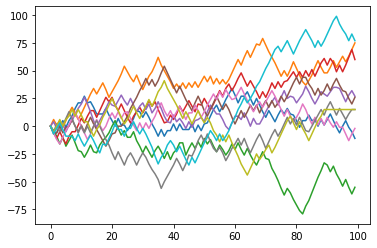

In [29]:
for rs in ratings_data[:10]:
    plt.plot(list(range(len(rs))), rs)

(array([592., 278.,  74.,  13.,   2.,   3.,   1.,   0.,   0.,   1.]),
 array([  0. ,  42.1,  84.2, 126.3, 168.4, 210.5, 252.6, 294.7, 336.8,
        378.9, 421. ]),
 <BarContainer object of 10 artists>)

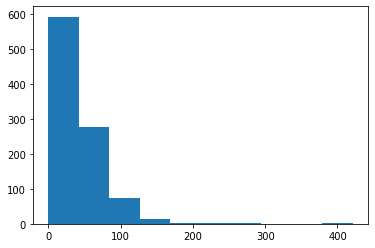

In [31]:
diffs = np.abs(ratings_data)
plt.hist(diffs[:,-1])

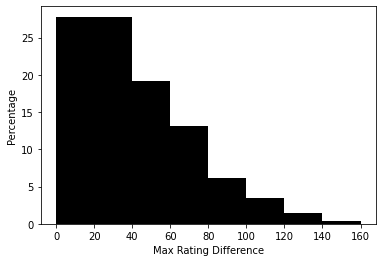

In [46]:
buckets = [(0,20), (20, 40), (40, 60), (60,80), (80,100), (100, 120), (120, 140), (140, 160)]
frac_by_bucket = collections.defaultdict(int)
N = len(ratings_data)
for rs in ratings_data:
    val = np.max(rs) # for max diff
    #val = rs[-1] # for final diff
    for bucket in reversed(buckets):
        lo, hi = bucket
        if lo <= val and val < hi:
            frac_by_bucket[lo] += 1
            break
for k in frac_by_bucket:
    frac_by_bucket[k] /= N
    frac_by_bucket[k] *= 100

xs = sorted(list(frac_by_bucket.keys()))
ys = [frac_by_bucket[k] for k in xs]
plt.bar(xs,
        ys,
        align="edge",
        color="black",
        width=20)
plt.xlabel("Max Rating Difference")
#plt.xlabel("Final Rating Difference")
plt.ylabel("Percentage")
plt.savefig("/tmp/real-max-diff.png")
#plt.savefig("/tmp/real-final-diff.png")

(0.0, 104.64211618257261)

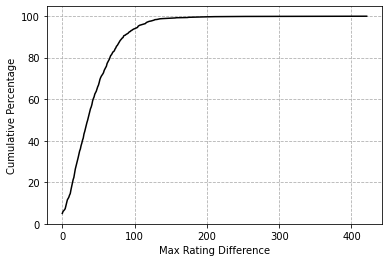

In [59]:
prev = -1
count = 0
xs = []
ys = []
cum = np.sort(np.max(ratings_data, axis=1))
N = len(cum)
for i, _ in enumerate(cum):
    if i+1 == len(cum) or cum[i+1] != cum[i]:
        xs.append(cum[i])
        ys.append(100*i/N)
plt.plot(xs, ys, color="black")
plt.grid(linestyle="--")
plt.ylabel("Cumulative Percentage")
plt.xlabel("Max Rating Difference")
plt.savefig("/tmp/real-max-diff-cumulative.png")
plt.ylim(bottom=0)